# Sommaire
 - <a href="#M1">Mission 1 : résumé des données utilisées.</a>
 - <a href="#M2">Mission 2 : distribution des revenus dans le monde.</a>
 - <a href="#M3">Mission 3 : génération aléatoire de la classe de revenu des parents par pays.</a>
 - <a href="#M4">Mission 4 : explication du revenu des individus en fonction du revenu moyen du pays, de l'indice de Gini du pays, de la classe de revenu des parents.</a>

In [1]:
import scipy
import pylab
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

from joblib import dump, load
from collections import Counter

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing, decomposition
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 40)

sns.set()

# <a name="M1">Mission 1</a>

## Résumé des données

### World Income Distribution

In [2]:
idd = pd.read_csv('idd.csv', encoding='utf_8', encoding_errors='strict')

In [3]:
idd[:15]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297
3,ALB,2008,4,100,"1086,9078",7297
4,ALB,2008,5,100,"1132,6997",7297
5,ALB,2008,6,100,"1171,1412",7297
6,ALB,2008,7,100,"1201,1324",7297
7,ALB,2008,8,100,"1240,8976",7297
8,ALB,2008,9,100,"1285,6914",7297
9,ALB,2008,10,100,"1325,2533",7297


In [4]:
idd['country']=='ALB'

0         True
1         True
2         True
3         True
4         True
         ...  
11594    False
11595    False
11596    False
11597    False
11598    False
Name: country, Length: 11599, dtype: bool

In [5]:
idd.loc[idd['country']=='ALB', :]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297
3,ALB,2008,4,100,"1086,9078",7297
4,ALB,2008,5,100,"1132,6997",7297
...,...,...,...,...,...,...
95,ALB,2008,96,100,"6231,0996",7297
96,ALB,2008,97,100,"6822,3184",7297
97,ALB,2008,98,100,"7775,891",7297
98,ALB,2008,99,100,"9351,751",7297


In [6]:
idd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country       11599 non-null  object
 1   year_survey   11599 non-null  int64 
 2   quantile      11599 non-null  int64 
 3   nb_quantiles  11599 non-null  int64 
 4   income        11599 non-null  object
 5   gdpppp        11399 non-null  object
dtypes: int64(3), object(3)
memory usage: 543.8+ KB


In [7]:
idd['income'] = idd['income'].str.replace(',', '.')
idd['gdpppp'] = idd['gdpppp'].str.replace(',', '.')
idd[:5]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297
1,ALB,2008,2,100,916.66235,7297
2,ALB,2008,3,100,1010.916,7297
3,ALB,2008,4,100,1086.9078,7297
4,ALB,2008,5,100,1132.6997,7297


In [8]:
idd['income'] = idd['income'].astype(float)
idd['gdpppp'] = idd['gdpppp'].astype(float)

#### Pays LTU, il manque une classe de revenus, le quantile n° 41 : imputation par la moyenne

In [9]:
idd.loc[idd['country']=='LTU', :].loc[6238:6242, :]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6238,LTU,2008,39,100,4802.3680,17571.0
6239,LTU,2008,40,100,4868.4507,17571.0
6240,LTU,2008,42,100,4895.8306,17571.0
6241,LTU,2008,43,100,4950.6380,17571.0
6242,LTU,2008,44,100,5006.7860,17571.0


In [10]:
q41 = ['LTU', 2008, 41, 100, np.mean([4895.8306, 4868.4507]), 17571.0]
q41

['LTU', 2008, 41, 100, 4882.14065, 17571.0]

In [11]:
idd[-1:]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
11598,COD,2008,100,100,2243.1226,303.19305


In [12]:
idd.loc[idd.index[-1]+1] = q41
idd[-1:]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
11599,LTU,2008,41,100,4882.14065,17571.0


In [13]:
idd = idd.sort_values(by=['country', 'quantile'])

In [14]:
idd = idd.reset_index(drop=True)

In [15]:
idd.loc[idd['country']=='LTU', :].loc[6238:6242, :]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6238,LTU,2008,39,100,4802.36800,17571.0
6239,LTU,2008,40,100,4868.45070,17571.0
6240,LTU,2008,41,100,4882.14065,17571.0
6241,LTU,2008,42,100,4895.83060,17571.0
6242,LTU,2008,43,100,4950.63800,17571.0


In [16]:
idd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11600 entries, 0 to 11599
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11600 non-null  object 
 1   year_survey   11600 non-null  int64  
 2   quantile      11600 non-null  int64  
 3   nb_quantiles  11600 non-null  int64  
 4   income        11600 non-null  float64
 5   gdpppp        11400 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 543.9+ KB


In [17]:
# Valeurs manquantes
idd.isna().sum()

country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
dtype: int64

In [18]:
idd.count()

country         11600
year_survey     11600
quantile        11600
nb_quantiles    11600
income          11600
gdpppp          11400
dtype: int64

In [19]:
# Duplicate (most commonly rows of data that are exactly the same across all columns)
idd.duplicated().any()

False

In [20]:
idd.describe(include='all')

,country,year_survey,quantile,nb_quantiles,income,gdpppp
count,11600,11600.000000,11600.000000,11600.0,11600.000000,1.140000e+04
unique,116,NaN,NaN,NaN,NaN,NaN
top,ALB,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.982759,50.500000,100.0,6069.121925,5.021841e+04
std,NaN,0.909593,28.867314,0.0,9413.786596,4.000513e+05
min,NaN,2004.000000,1.000000,100.0,16.719418,3.031931e+02
25%,NaN,2008.000000,25.750000,100.0,900.768507,2.576000e+03
50%,NaN,2008.000000,50.500000,100.0,2403.492950,7.709000e+03
75%,NaN,2008.000000,75.250000,100.0,7515.313700,1.877300e+04


In [21]:
print('Années des sondages :')
print(*np.sort(idd['year_survey'].unique()), sep=', ')

Années des sondages :
2004, 2006, 2007, 2008, 2009, 2010, 2011


In [22]:
print('Nombre de pays :')
print(idd['country'].nunique())

Nombre de pays :
116


### Population

In [23]:
pop = pd.read_csv('pop.csv', encoding='utf_8', encoding_errors='strict')

In [24]:
pop[:5]

,Domain Code,Domain,Area Code (ISO3),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,OA,Annual population,AFG,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,27722.276,X,International reliable sources,NaN
1,OA,Annual population,ALB,Albania,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,3002.678,X,International reliable sources,NaN
2,OA,Annual population,DZA,Algeria,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,34730.608,X,International reliable sources,NaN
3,OA,Annual population,ASM,American Samoa,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,57.492,X,International reliable sources,NaN
4,OA,Annual population,AND,Andorra,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,83.862,X,International reliable sources,NaN


In [25]:
pop = pop.loc[:, ['Area Code (ISO3)', 'Value']]
pop[:5]

,Area Code (ISO3),Value
0,AFG,27722.276
1,ALB,3002.678
2,DZA,34730.608
3,ASM,57.492
4,AND,83.862


In [26]:
pop['Population'] = pop['Value'] * 1000
pop[:5]

,Area Code (ISO3),Value,Population
0,AFG,27722.276,27722276.0
1,ALB,3002.678,3002678.0
2,DZA,34730.608,34730608.0
3,ASM,57.492,57492.0
4,AND,83.862,83862.0


In [27]:
pop = pop.drop(columns='Value')
pop[:5]

,Area Code (ISO3),Population
0,AFG,27722276.0
1,ALB,3002678.0
2,DZA,34730608.0
3,ASM,57492.0
4,AND,83862.0


In [28]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Area Code (ISO3)  248 non-null    object 
 1   Population        231 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.0+ KB


In [29]:
# Valeurs manquantes
pop.isna().sum()

Area Code (ISO3)     0
Population          17
dtype: int64

In [30]:
pop.count()

Area Code (ISO3)    248
Population          231
dtype: int64

In [31]:
# Duplicate (most commonly rows of data that are exactly the same across all columns)
pop.duplicated().any()

False

In [32]:
pop.describe(include='all')

,Area Code (ISO3),Population
count,248,2.310000e+02
unique,248,NaN
top,AFG,NaN
freq,1,NaN
mean,NaN,3.538127e+07
std,NaN,1.520244e+08
min,NaN,7.940000e+02
25%,NaN,4.067280e+05
50%,NaN,4.775804e+06
75%,NaN,1.979478e+07


### Indice de Gini

In [33]:
gini = pd.read_csv('gini.csv', encoding='utf_8', encoding_errors='strict')

In [34]:
gini[:5]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
0,Aruba,ABW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN,NaN,NaN


In [35]:
gini = gini.iloc[:, :-1]
gini

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,NaN,31.2,30.3,NaN,NaN,31.8,33.3,27.8,29.0,26.3,27.3,26.5,26.7,29.0,NaN,NaN,NaN,NaN
262,"Yemen, Rep.",YEM,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,NaN,NaN,NaN,NaN,NaN,NaN,34.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,South Africa,ZAF,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.3,NaN,NaN,NaN,NaN,NaN,NaN,57.8,NaN,NaN,NaN,NaN,64.8,NaN,NaN,63.0,NaN,63.4,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264,Zambia,ZMB,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.5,NaN,52.6,NaN,NaN,48.3,NaN,49.1,NaN,NaN,NaN,42.1,NaN,54.3,NaN,54.6,NaN,NaN,NaN,55.6,NaN,NaN,NaN,NaN,57.1,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
gini = gini.drop(columns=['Indicator Name', 'Indicator Code'])
gini[:5]

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN,NaN


In [37]:
gini.set_index(['Country Name', 'Country Code'], inplace=True)
gini[:5]

,,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Country Name,Country Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Africa Eastern and Southern,AFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Africa Western and Central,AFW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN,NaN


In [38]:
gini = gini.loc[:, '2000':'2020']

In [39]:
gini = gini.dropna(axis='index', how='all')
gini

,,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country Name,Country Code,,,,,,,,,,,,,,,,,,,,,
Angola,AGO,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN
Albania,ALB,NaN,NaN,31.7,NaN,NaN,30.6,NaN,NaN,30.0,NaN,NaN,NaN,29.0,NaN,34.6,32.8,33.7,33.1,30.1,30.8,NaN
United Arab Emirates,ARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.5,NaN,NaN,NaN,NaN,26.0,NaN,NaN
Argentina,ARG,51.1,53.3,53.8,50.9,48.4,47.7,46.3,46.2,44.9,43.7,43.6,42.6,41.3,40.9,41.6,NaN,42.0,41.1,41.3,42.9,42.3
Armenia,ARM,NaN,35.4,34.8,33.0,37.5,36.0,29.7,31.2,29.2,28.0,30.0,29.4,29.6,30.6,31.5,32.4,32.5,33.6,34.4,29.9,25.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kosovo,XKX,NaN,NaN,NaN,29.0,NaN,31.2,30.3,NaN,NaN,31.8,33.3,27.8,29.0,26.3,27.3,26.5,26.7,29.0,NaN,NaN,NaN
"Yemen, Rep.",YEM,NaN,NaN,NaN,NaN,NaN,34.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.7,NaN,NaN,NaN,NaN,NaN,NaN
South Africa,ZAF,57.8,NaN,NaN,NaN,NaN,64.8,NaN,NaN,63.0,NaN,63.4,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
gini['Gini index'] = gini.mean(axis=1)
gini['Gini index'] = gini['Gini index'].round().astype(int)
gini

,,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Gini index
Country Name,Country Code,,,,,,,,,,,,,,,,,,,,,,
Angola,AGO,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN,49
Albania,ALB,NaN,NaN,31.7,NaN,NaN,30.6,NaN,NaN,30.0,NaN,NaN,NaN,29.0,NaN,34.6,32.8,33.7,33.1,30.1,30.8,NaN,32
United Arab Emirates,ARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.5,NaN,NaN,NaN,NaN,26.0,NaN,NaN,29
Argentina,ARG,51.1,53.3,53.8,50.9,48.4,47.7,46.3,46.2,44.9,43.7,43.6,42.6,41.3,40.9,41.6,NaN,42.0,41.1,41.3,42.9,42.3,45
Armenia,ARM,NaN,35.4,34.8,33.0,37.5,36.0,29.7,31.2,29.2,28.0,30.0,29.4,29.6,30.6,31.5,32.4,32.5,33.6,34.4,29.9,25.2,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kosovo,XKX,NaN,NaN,NaN,29.0,NaN,31.2,30.3,NaN,NaN,31.8,33.3,27.8,29.0,26.3,27.3,26.5,26.7,29.0,NaN,NaN,NaN,29
"Yemen, Rep.",YEM,NaN,NaN,NaN,NaN,NaN,34.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.7,NaN,NaN,NaN,NaN,NaN,NaN,36
South Africa,ZAF,57.8,NaN,NaN,NaN,NaN,64.8,NaN,NaN,63.0,NaN,63.4,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,NaN,62


In [41]:
gini = gini[['Gini index']]
gini.reset_index(inplace=True)
gini

,Country Name,Country Code,Gini index
0,Angola,AGO,49
1,Albania,ALB,32
2,United Arab Emirates,ARE,29
3,Argentina,ARG,45
4,Armenia,ARM,32
...,...,...,...
158,Kosovo,XKX,29
159,"Yemen, Rep.",YEM,36
160,South Africa,ZAF,62
161,Zambia,ZMB,53


In [42]:
gini_sorted = gini.sort_values(by='Gini index', ascending=True).reset_index(drop=True)
gini_sorted

,Country Name,Country Code,Gini index
0,Slovenia,SVN,25
1,Czech Republic,CZE,26
2,Ukraine,UKR,26
3,Slovak Republic,SVK,26
4,Norway,NOR,27
...,...,...,...
158,Brazil,BRA,54
159,Central African Republic,CAF,56
160,Botswana,BWA,60
161,Namibia,NAM,61


In [43]:
print('Index de Gini moyen :', int(np.round(gini['Gini index'].mean())))

Index de Gini moyen : 39


In [44]:
print('5 meilleurs indices : \n')
gini_sorted[:5]

5 meilleurs indices : 



,Country Name,Country Code,Gini index
0,Slovenia,SVN,25
1,Czech Republic,CZE,26
2,Ukraine,UKR,26
3,Slovak Republic,SVK,26
4,Norway,NOR,27


In [45]:
print('5 moins bons indices : \n')
gini_sorted[-5:]

5 moins bons indices : 



,Country Name,Country Code,Gini index
158,Brazil,BRA,54
159,Central African Republic,CAF,56
160,Botswana,BWA,60
161,Namibia,NAM,61
162,South Africa,ZAF,62


In [46]:
print('Position de la France par rapport aux meilleurs : \n')
gini_sorted.loc[(gini_sorted['Country Name']=='France'), :]

Position de la France par rapport aux meilleurs : 



,Country Name,Country Code,Gini index
33,France,FRA,32


In [47]:
gini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Name  163 non-null    object
 1   Country Code  163 non-null    object
 2   Gini index    163 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.9+ KB


In [48]:
# Valeurs manquantes
gini.isna().sum()

Country Name    0
Country Code    0
Gini index      0
dtype: int64

In [49]:
gini.count()

Country Name    163
Country Code    163
Gini index      163
dtype: int64

In [50]:
# Duplicate (most commonly rows of data that are exactly the same across all columns)
gini.duplicated().any()

False

In [51]:
gini.describe(include='all')

,Country Name,Country Code,Gini index
count,163,163,163.000000
unique,163,163,NaN
top,Angola,AGO,NaN
freq,1,1,NaN
mean,NaN,NaN,38.570552
std,NaN,NaN,7.714000
min,NaN,NaN,25.000000
25%,NaN,NaN,33.000000
50%,NaN,NaN,37.000000
75%,NaN,NaN,43.000000


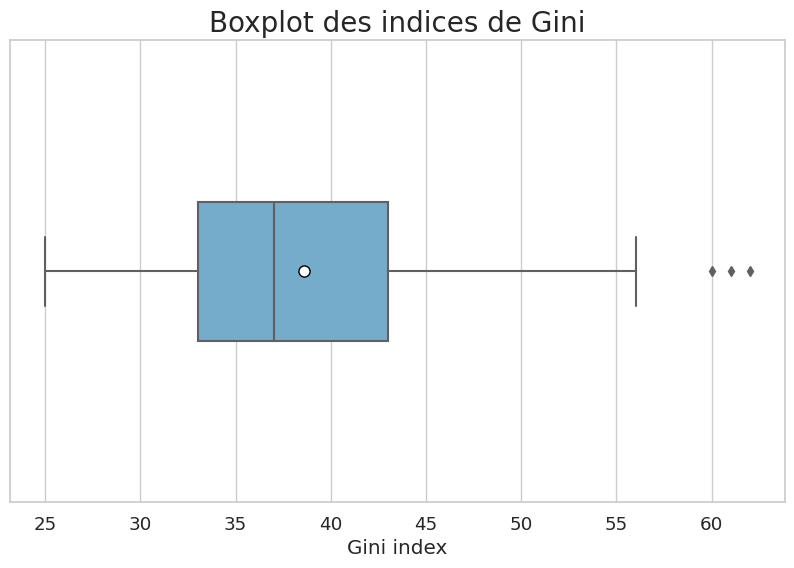

In [52]:
sns.set(font_scale=1.2, style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

_ = ax.set_title('Boxplot des indices de Gini', fontsize=20)

g = sns.boxplot(ax=ax, orient='h', data=gini, x='Gini index', palette='Blues', width=0.3,
                showmeans=True, showfliers=True, saturation=0.8, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})

plt.show();

# <a name="M2">Mission 2, distribution des revenus dans le monde.</a>

### Exemple avec 6 pays

In [53]:
idd[:5]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


In [54]:
grp = idd.groupby('country')[['income']].max().sort_values(ascending=False, by='income')
grp

,income
country,
USA,176928.5500
ISL,160645.2700
GBR,141565.2300
CAN,133454.8400
FRA,122775.1640
...,...
MDG,3164.7986
MLI,2958.8750
CIV,2814.3389


In [55]:
nb_pays = 6
a = pd.DataFrame(pd.qcut(grp['income'], q=nb_pays, labels=range(1, nb_pays+1)))
# GroupBy.nth(n, dropna=None)[source]
# Take the nth row from each group if n is an int, or a subset of rows if n is a list of ints.
b = a.groupby('income').nth(0).sort_values(by='income', ascending=False)
a

,income
country,
USA,6
ISL,6
GBR,6
CAN,6
FRA,6
...,...
MDG,1
MLI,1
CIV,1


In [56]:
country_list = list(b.index)
country_list

['USA', 'AUT', 'TUR', 'NIC', 'IDN', 'ARM']

In [57]:
clist = idd.loc[(idd['country'].isin(country_list)), :]

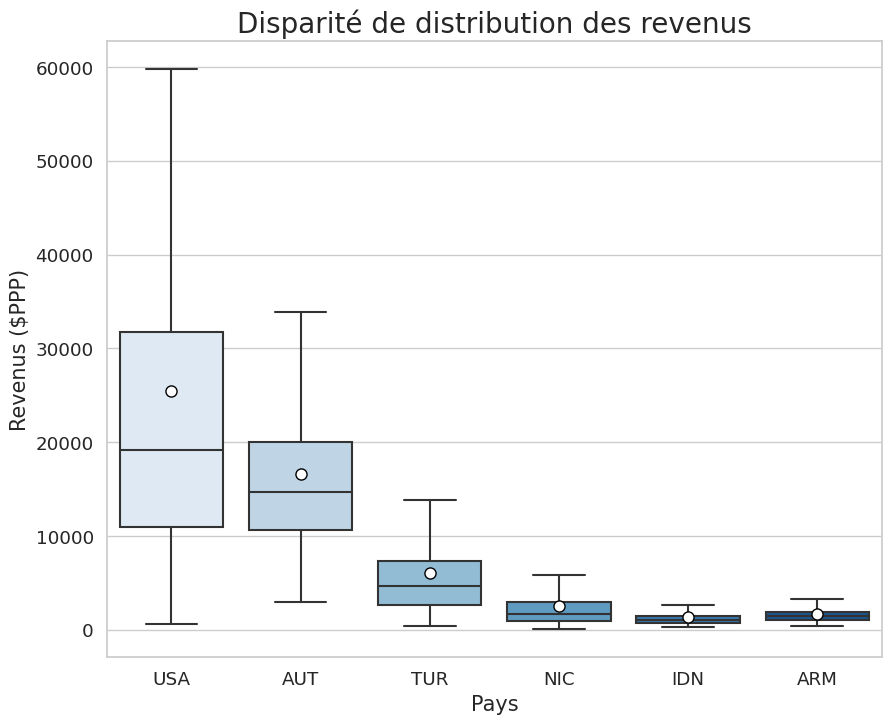

In [58]:
sns.set(font_scale=1.2, style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

_ = ax.set_title ('Disparité de distribution des revenus', fontsize=20)

g = sns.boxplot(ax=ax, orient='v', data=clist, y='income', x='country', palette='Blues', order = country_list,
                showmeans=True, showfliers=False, saturation=0.8, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})

# nom des axes
plt.ylabel(f'Revenus ($PPP)', fontsize='15')
plt.xlabel(f'Pays', fontsize='15')

# plt.savefig('Distribution des revenus (6 pays).png', transparent=True)
plt.show();

In [59]:
country_list = ['FRA', 'ESP', 'CZE', 'SRB', 'KAZ', 'TZA']

In [60]:
# qcut_series, qcut_intervals = pd.qcut(grp['income'], q=5, labels=range(1, 6), retbins=True)
# print(qcut_series.value_counts())
# print('\nintervals', *qcut_intervals, sep=', ')

In [61]:
idd[:5]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


In [62]:
clist = idd.loc[(idd['country'].isin(country_list)), :]

In [63]:
# sns.set(font_scale=1.2, style='whitegrid')

# fig, axes = plt.subplots(6, 1, figsize=(10, 12))
# fig.suptitle('Boxplots des 6 pays sélectionnés', fontsize=20)

# # xx = [0,0,0,1,1,1]
# # yy = [0,1,2,0,1,2]

# xx = [0,1,2,3,4,5]
# yy = [0,0,0,0,0,0]

# for a, b in enumerate(country_list):
    
#     ax = axes[xx[a]]
    
#     g = sns.boxplot(ax=ax, orient='h', data=clist.loc[(clist['country']==b), :], x='income', palette='Blues',
#                     showmeans=True, showfliers=False, saturation=0.8, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
    
#     g.set(xlabel=b)
#     g.set_xscale('log')
#     g.set_xlim(80, 50000)

# #plt.savefig('Boxplots des 6 variables explicatives.png', transparent=True)
# fig.tight_layout()
# plt.show();

In [64]:
# sns.set(font_scale=1.2, style='whitegrid')
# fig, ax = plt.subplots(figsize=(10, 8))

# _ = ax.set_title ('Disparité de distribution des revenus', fontsize=20)

# g = sns.boxplot(ax=ax, orient='v', data=clist, y='income', x='country', palette='Blues', order = country_list,
#                 showmeans=True, showfliers=False, saturation=0.8, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})

# g.set_yscale('log')

# # nom des axes
# plt.ylabel(f'Revenus (log $PPP)', fontsize='15')
# plt.xlabel(f'Pays', fontsize='15')

# plt.savefig('Distribution des revenus (6 pays).png', transparent=True)
# plt.show();

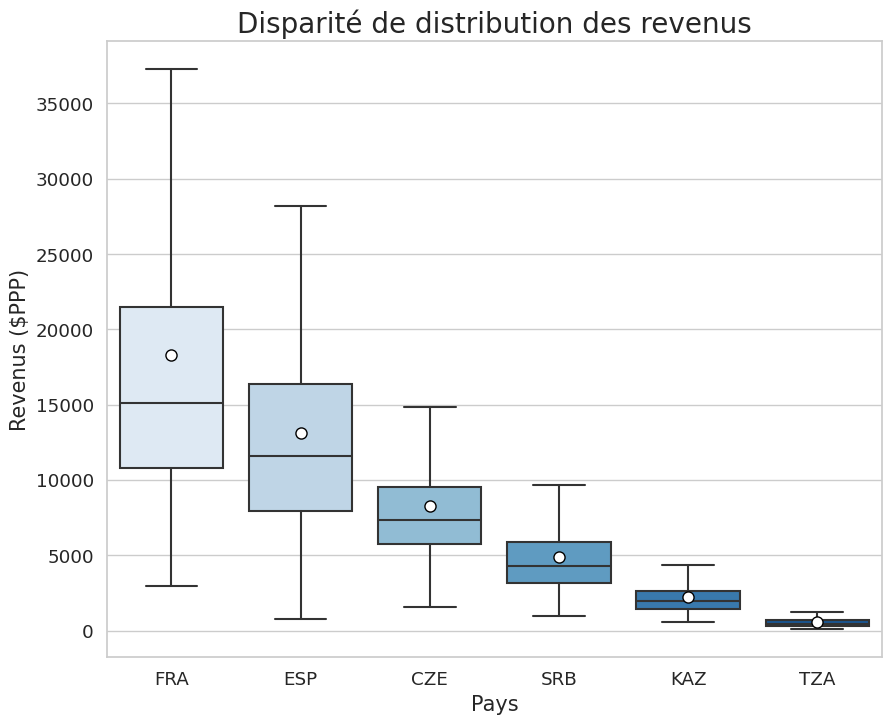

In [65]:
sns.set(font_scale=1.2, style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

_ = ax.set_title ('Disparité de distribution des revenus', fontsize=20)

g = sns.boxplot(ax=ax, orient='v', data=clist, y='income', x='country', palette='Blues', order = country_list,
                showmeans=True, showfliers=False, saturation=0.8, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})

# nom des axes
plt.ylabel(f'Revenus ($PPP)', fontsize='15')
plt.xlabel(f'Pays', fontsize='15')

# plt.savefig('Distribution des revenus (6 pays).png', transparent=True)
plt.show();

In [66]:
# sns.set(style='whitegrid')

# #Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(12, 10))

# g = sns.barplot(data=usa, x='quantile', y='income', palette='rocket_r', saturation=0.1)
# g.set_yscale('log')

# plt.xticks(range(-1, 100, 10))
# plt.ylabel('Revenu moyen')
# plt.xlabel('Classes de revenus')
# plt.title ('Distribution des revenus (USA)', fontsize=20)
# plt.show()

In [67]:
# sns.set(style='whitegrid')

# for i in country_list:

#     sns.catplot(data=idd.loc[(idd['country']==i), :], x='quantile', y='income', height=5, aspect=2, kind='bar', palette='viridis')
#     plt.xticks(range(-1, 100, 10))
#     plt.ylabel('Revenu moyen')
#     plt.xlabel('Classes de revenus')
#     plt.title(f'Distribution des revenus ({i})')

# plt.show()

In [68]:
# sns.displot(clist, x='income', hue='country', hue_order=country_list, log_scale=True, bins=50, height=10, aspect=1)
# plt.ylabel('Fréquence')
# plt.xlabel('Revenus (log $PPP)')
# plt.title('Distribution des revenus (6 pays)', fontsize=20)
# plt.show();

In [69]:
clist_mean = clist.groupby('country')[['income']].mean().sort_values(by='income', ascending=False)
clist_mean

,income
country,
FRA,18309.407545
ESP,13116.992910
CZE,8235.293411
SRB,4879.750852
KAZ,2239.149800
TZA,588.766986


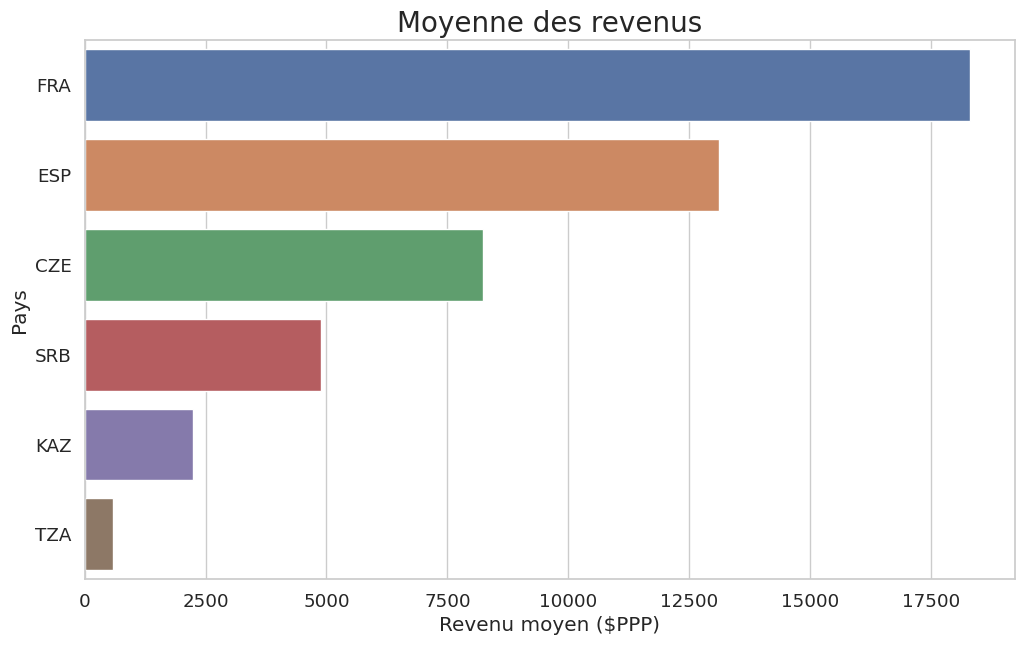

In [70]:
plt.figure(figsize=(12, 7))
sns.barplot(data=clist_mean, x='income', y=clist_mean.index)
plt.ylabel('Pays')
plt.xlabel('Revenu moyen ($PPP)')
plt.title('Moyenne des revenus', fontsize=20)
# plt.savefig('Moyenne des revenus (6 pays).png', transparent=True)
plt.show();

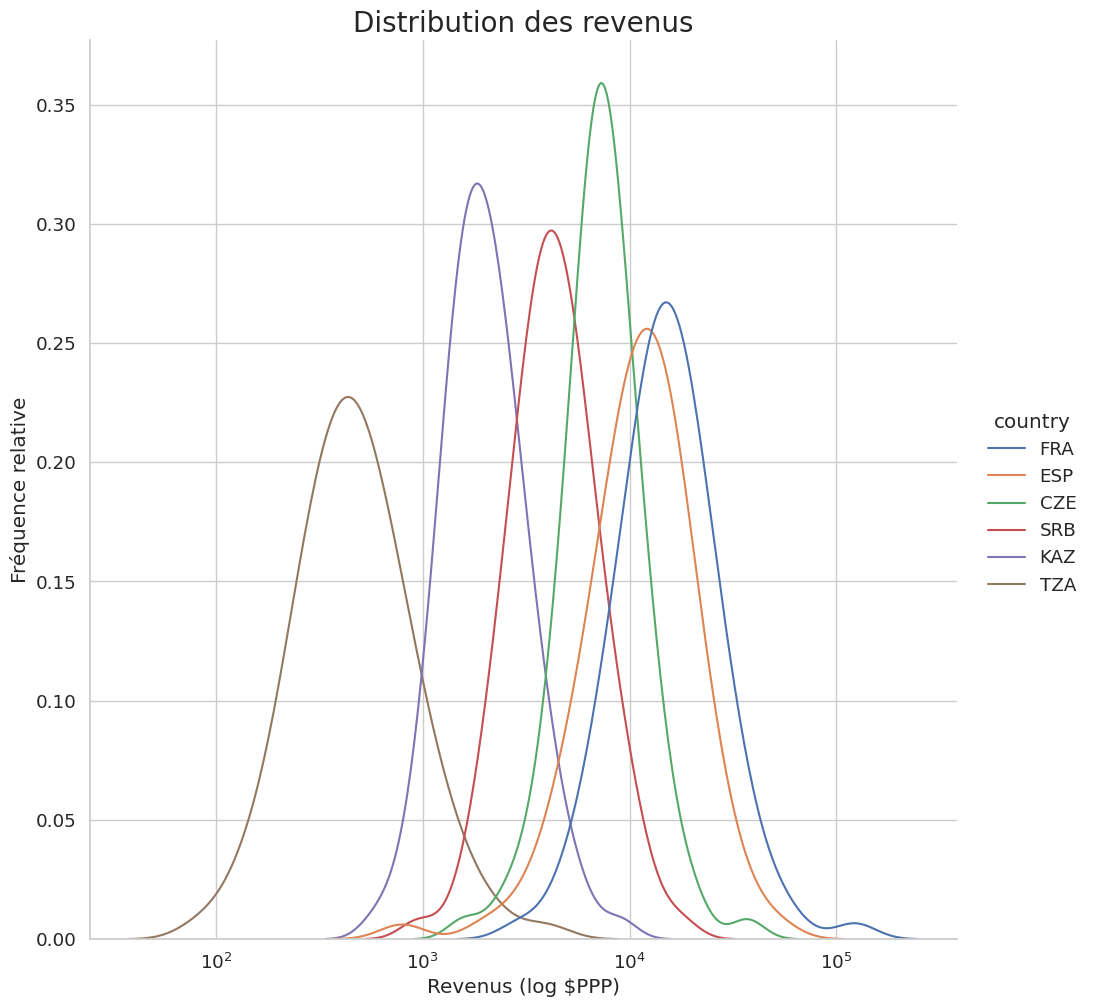

In [71]:
sns.displot(data=clist, x='income', hue='country', hue_order=country_list, log_scale=True, height=10, aspect=1, kind='kde')
plt.ylabel('Fréquence relative')
plt.xlabel('Revenus (log $PPP)')
plt.title('Distribution des revenus', fontsize=20)
plt.show();

In [72]:
# f, ax = plt.subplots(figsize=(8, 4))
# f.suptitle('Revenu moyen par habitant des USA', fontsize=20)
# g = sns.boxplot(data=idd.loc[(idd['country']=='USA'), :], x='income', orient='h',  width=.4, saturation=0.8, color='tab:blue', showfliers=False);

In [73]:
#data = idd.loc[(idd['country'].isin(country_list)), :].sort_values(by='gdpppp', ascending=False)
data = idd.loc[(idd['country'].isin(country_list)), :]
data[:10]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
2400,CZE,2008,1,100,1586.2471,23223.0
2401,CZE,2008,2,100,2322.1792,23223.0
2402,CZE,2008,3,100,2741.5847,23223.0
2403,CZE,2008,4,100,3067.3618,23223.0
2404,CZE,2008,5,100,3395.3267,23223.0
2405,CZE,2008,6,100,3607.9130,23223.0
2406,CZE,2008,7,100,3802.4858,23223.0
2407,CZE,2008,8,100,3974.2010,23223.0
2408,CZE,2008,9,100,4111.6743,23223.0
2409,CZE,2008,10,100,4231.9260,23223.0


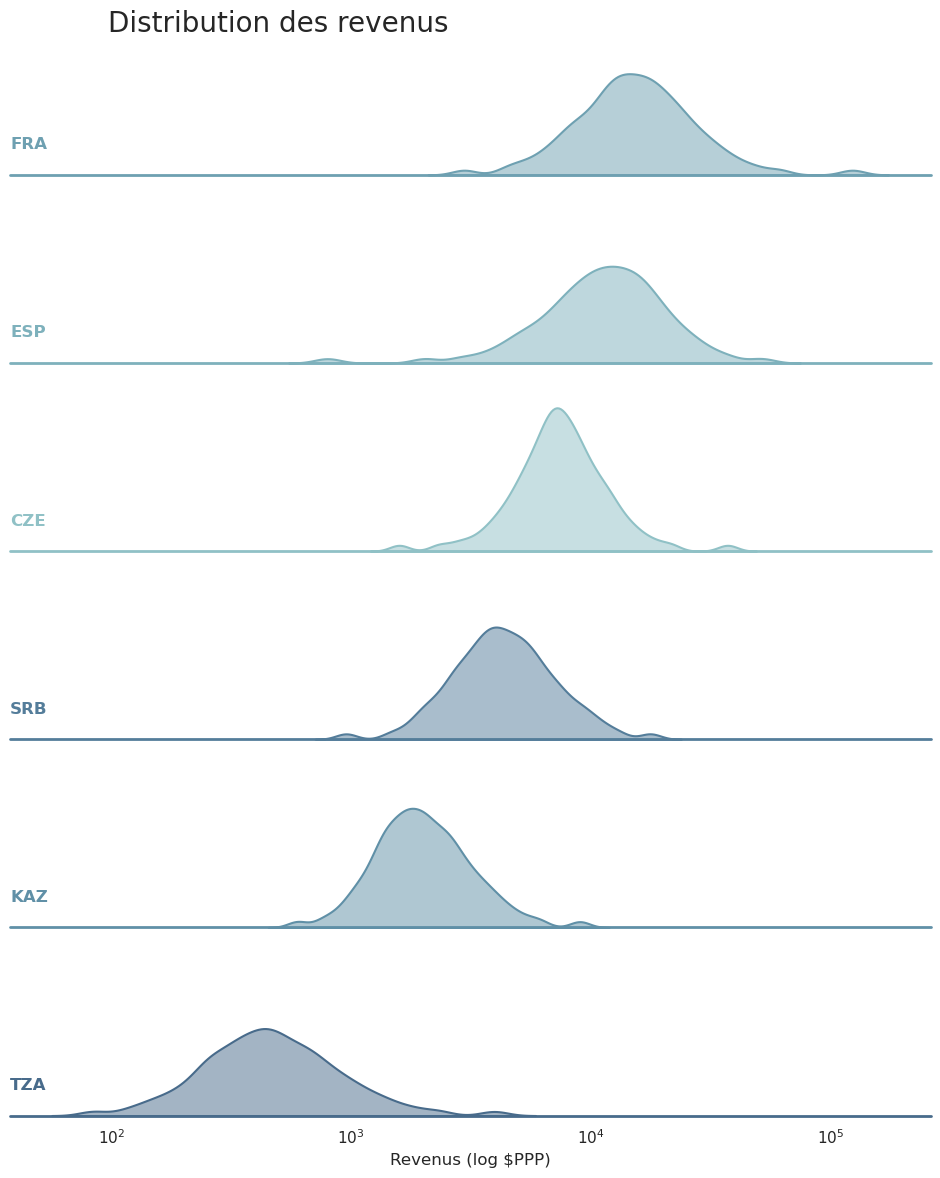

In [74]:
sns.set_theme(style='white', rc={'axes.facecolor': (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(data, row='country', hue='country', aspect=5, height=2, palette=pal, row_order=country_list)

# Draw the densities
g.map(sns.kdeplot, 'income', bw_adjust=.5, clip_on=False, log_scale=True, fill=True, alpha=.5, linewidth=1.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle='-', color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight='bold', color=color, ha='left', va='center', transform=ax.transAxes)
    
g.map(label, 'income')

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=.25)

# Remove axes details that don't play well with overlap
g.set_titles('')
g.set(yticks=[], ylabel='')
g.despine(bottom=True, left=True)
plt.xlabel('Revenus (log $PPP)', fontsize=12)
plt.suptitle('Distribution des revenus', fontsize=20, ha='right');

--------------------
ESP
moyenne:
 13116.9929096
médiane:
 11579.4535
variance:
 61490544.11378437
écart type:
 7841.59066221799
kurtosis:
 5.3792364410110345
skewness:
 1.7786662131943882


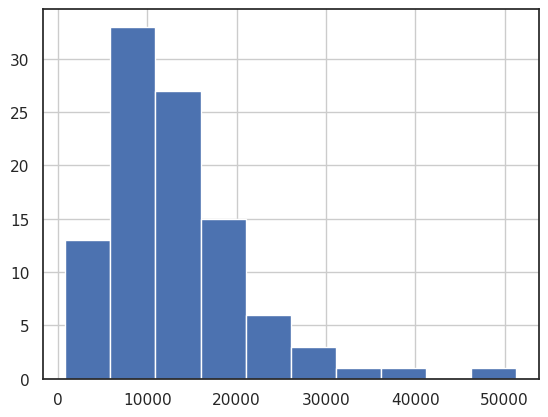

--------------------
FRA
moyenne:
 18309.407545
médiane:
 15092.115
variance:
 205982078.9290721
écart type:
 14352.075770740346
kurtosis:
 27.828293350013
skewness:
 4.339983017533462


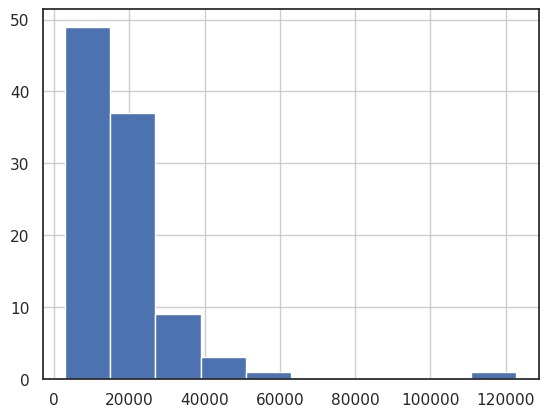

In [75]:
# skewness > 0 alors la distribution est étalée à droite : la moyenne est supérieure à la médiane

for cat in ['ESP', 'FRA']:
    subset = clist.loc[clist['country'] == cat, :]
    print("-"*20)
    print(cat)
    print("moyenne:\n",subset['income'].mean())
    print("médiane:\n",subset['income'].median())
    print("variance:\n",subset['income'].var(ddof=0))
    print("écart type:\n",subset['income'].std(ddof=0))
    print("kurtosis:\n",subset['income'].kurtosis())
    print("skewness:\n",subset['income'].skew())
    subset['income'].hist()
    plt.show()

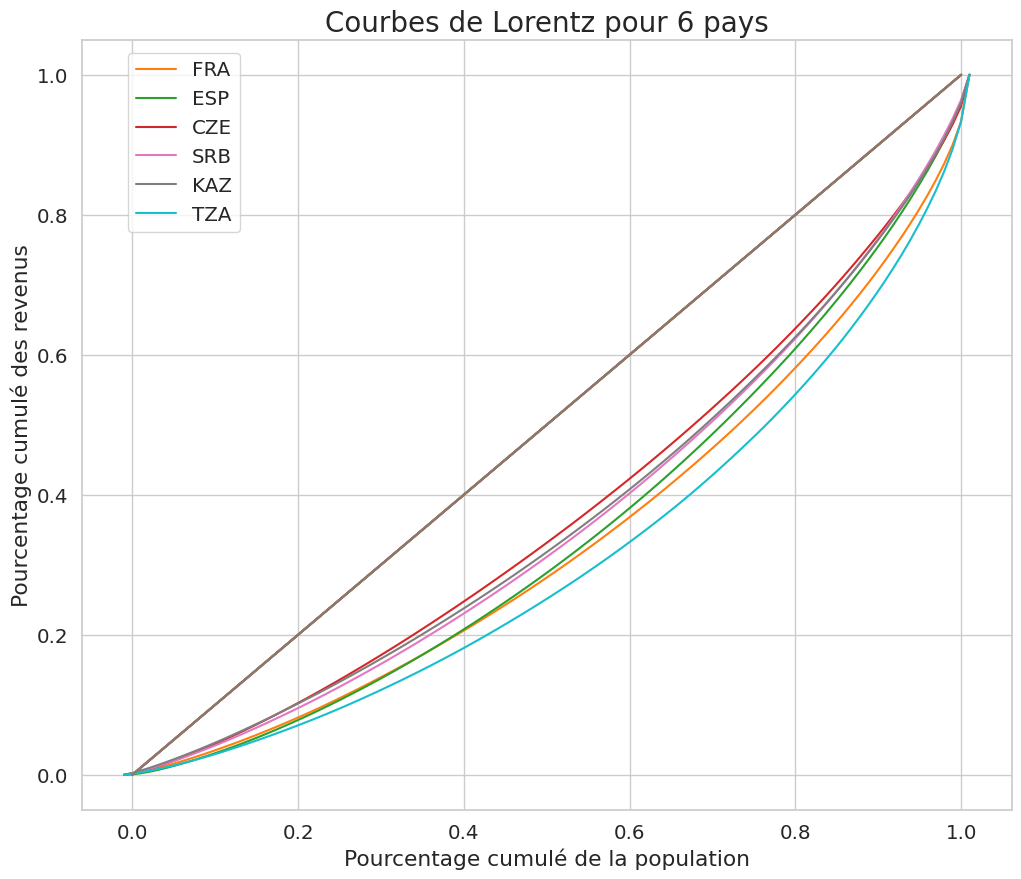

In [76]:
sns.set(font_scale=1.3, style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 10))
_ = ax.set_title ('Courbes de Lorentz pour 6 pays', fontsize=20)
colors = ['tab:orange', 'tab:green', 'tab:red', 'tab:pink', 'tab:grey', 'tab:cyan']

for count, country in enumerate(country_list):

    dep = clist.loc[(clist['country']==country), 'income'].to_numpy()
    n = len(dep)
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()
    lorenz = np.append([0], lorenz) 
    xaxis = np.linspace(0-1/n, 1+1/n, len(lorenz)) 

    ax.plot(xaxis, lorenz, label=f'{country}', color=colors[count])
    ax.plot([0,1], [0,1]) # bissectrice
    ax.set_xlabel('Pourcentage cumulé de la population')
    ax.set_ylabel('Pourcentage cumulé des revenus')
    ax.legend(loc=(0.05, 0.75))
    
# plt.savefig('Courbes de Lorentz.png', transparent=True)
    
plt.show();

# <a name="M3">Mission 3, génération aléatoire de la classe de revenu des parents par pays.</a>

### Elasticity

In [77]:
df_elasticity = pd.read_csv('gdim.csv', encoding='utf_8', encoding_errors='strict')

In [78]:
df_elasticity[:5]

,country,code,region,region_noHICgroup,incgroup2,incgroup3,incgroup4,fragile,survey,year,status,cohort,parent,child,obs,P1,P2,P3,P4,P5,C1,C2,C3,C4,C5,MEANp,MEANc,SDp,SDc,MLD_psu,CAT,YOS,DIF,MIX,CAT_ISCED0,CAT_ISCED1,CAT_ISCED2,CAT_ISCED34,CAT_ISCED5678,COR,BETA,MU050,BHQ4,Q4Q4,BHQ1,BHQ2,BHQ3,Q4BH,Q4child
0,Afghanistan,AFG,South Asia,South Asia,Developing economies,Low income,Low income,Yes,NRVA,2011,Co-residents only,1980,avg,all,3956,0.666125,0.098583,0.170931,0.043031,0.021330,0.511857,0.025805,0.164191,0.183469,0.114678,2.480162,5.582401,3.809782,5.857765,0.117092,0.414355,0.480076,3.203298,0.416691,0.329975,0.633108,0.584747,0.542553,0.0,0.521676,0.802107,38.267929,0.115412,0.576567,0.343300,0.325300,0.215988,0.160665,0.250315
1,Afghanistan,AFG,South Asia,South Asia,Developing economies,Low income,Low income,Yes,NRVA,2011,Co-residents only,1980,avg,daughter,721,0.615321,0.099272,0.212776,0.051969,0.020662,0.628481,0.023378,0.099265,0.132322,0.116553,2.989992,4.331731,4.010379,5.902685,0.253321,0.283075,0.313359,1.433388,0.284895,0.174239,0.509354,0.445407,0.474830,0.0,0.576251,0.848156,31.926859,0.069982,0.505354,0.439815,0.384448,0.105754,0.284408,0.216944
2,Afghanistan,AFG,South Asia,South Asia,Developing economies,Low income,Low income,Yes,NRVA,2011,Co-residents only,1980,avg,son,3235,0.678699,0.098412,0.160574,0.040819,0.021495,0.482992,0.026405,0.180261,0.196128,0.114214,2.353979,5.891941,3.748495,5.806141,0.123467,0.446874,0.521339,3.641724,0.449310,0.364921,0.664005,0.630444,0.563892,0.0,0.521442,0.807674,39.630493,0.125021,0.599029,0.322886,0.312750,0.239342,0.121790,0.258574
3,Afghanistan,AFG,South Asia,South Asia,Developing economies,Low income,Low income,Yes,NRVA,2011,Co-residents only,1980,dad,all,4137,0.686581,0.047610,0.057309,0.150907,0.057594,0.514562,0.026047,0.165638,0.181551,0.112202,3.756049,5.538275,5.493762,5.842035,0.117092,0.350244,0.372781,2.110216,0.354333,0.342107,0.731783,0.366321,0.260787,0.0,0.483760,0.514428,40.513165,0.128599,0.549514,0.335149,0.316313,0.219938,0.192943,0.250296
4,Afghanistan,AFG,South Asia,South Asia,Developing economies,Low income,Low income,Yes,NRVA,2011,Co-residents only,1980,dad,daughter,744,0.639092,0.052328,0.054086,0.190100,0.064394,0.630354,0.022781,0.103736,0.129553,0.113576,4.520877,4.277768,5.804775,5.869737,0.253321,0.230126,0.235220,0.128818,0.235170,0.189864,0.819140,0.233389,0.202416,0.0,0.486349,0.491792,31.846794,0.081535,0.491902,0.429669,0.378788,0.110007,0.315896,0.211575


In [79]:
df_elasticity.shape

(6725, 49)

In [80]:
el = df_elasticity.loc[:, ['country', 'code', 'year', 'cohort', 'parent', 'child', 'CAT']]
el[:5]

,country,code,year,cohort,parent,child,CAT
0,Afghanistan,AFG,2011,1980,avg,all,0.414355
1,Afghanistan,AFG,2011,1980,avg,daughter,0.283075
2,Afghanistan,AFG,2011,1980,avg,son,0.446874
3,Afghanistan,AFG,2011,1980,dad,all,0.350244
4,Afghanistan,AFG,2011,1980,dad,daughter,0.230126


In [81]:
el.shape

(6725, 7)

In [82]:
el['code'].nunique()

153

In [83]:
# suppression des lignes cohort = 1940
filt = (el['cohort'] == 1940)
el = el.drop(el[filt].index)

In [84]:
el.shape

(5536, 7)

In [85]:
el['code'].nunique()

153

In [86]:
# sélection parent = max
filt = (el['parent'] == 'max')
el = el.loc[filt, :]

In [87]:
el.shape

(1477, 7)

In [88]:
el['code'].nunique()

153

In [89]:
# sélection child = all
filt = (el['child'] == 'all')
el = el.loc[filt, :]

In [90]:
el.shape

(494, 7)

In [91]:
el['code'].nunique()

153

In [92]:
el.info()

<class 'pandas.core.frame.DataFrame'>
Index: 494 entries, 6 to 6719
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  494 non-null    object 
 1   code     494 non-null    object 
 2   year     494 non-null    int64  
 3   cohort   494 non-null    int64  
 4   parent   494 non-null    object 
 5   child    494 non-null    object 
 6   CAT      494 non-null    float64
dtypes: float64(1), int64(2), object(4)
memory usage: 30.9+ KB


In [93]:
# Valeurs manquantes
el.isna().sum()

country    0
code       0
year       0
cohort     0
parent     0
child      0
CAT        0
dtype: int64

In [94]:
# Duplicate (most commonly rows of data that are exactly the same across all columns)
el.duplicated().any()

False

In [95]:
el['cohort'].unique()

array([1980, 1950, 1960, 1970])

In [96]:
el[el.duplicated(subset=['country', 'code', 'year', 'cohort', 'CAT'], keep=False)].sort_values(by=['country'])

,country,code,year,cohort,parent,child,CAT


In [97]:
el.describe(include='all')

,country,code,year,cohort,parent,child,CAT
count,494,494,494.000000,494.000000,494,494,494.000000
unique,153,153,NaN,NaN,1,1,NaN
top,Lao PDR,LAO,NaN,NaN,max,all,NaN
freq,4,4,NaN,NaN,494,494,NaN
mean,NaN,NaN,2013.350202,1966.214575,NaN,NaN,0.510662
std,NaN,NaN,4.187883,11.466616,NaN,NaN,0.189972
min,NaN,NaN,1991.000000,1950.000000,NaN,NaN,0.050492
25%,NaN,NaN,2012.000000,1960.000000,NaN,NaN,0.379625
50%,NaN,NaN,2014.500000,1970.000000,NaN,NaN,0.522490
75%,NaN,NaN,2016.000000,1980.000000,NaN,NaN,0.657535


In [98]:
cat_mean = el.groupby('code')[['CAT']].mean()
cat_mean[:5]

,CAT
code,
AFG,0.336376
AGO,0.501068
ALB,0.668573
ARG,0.594954
ARM,0.321540


In [99]:
col_names = ['CAT mean']
cat_mean.columns = col_names
cat_mean[:5]

,CAT mean
code,
AFG,0.336376
AGO,0.501068
ALB,0.668573
ARG,0.594954
ARM,0.321540


In [100]:
cat_mean.index.nunique()

153

In [101]:
el['code'].nunique()

153

In [102]:
el = pd.merge(el, cat_mean, how='left', on='code')
el

,country,code,year,cohort,parent,child,CAT,CAT mean
0,Afghanistan,AFG,2011,1980,max,all,0.336376,0.336376
1,Angola,AGO,2008,1980,max,all,0.501068,0.501068
2,Albania,ALB,2016,1950,max,all,0.715610,0.668573
3,Albania,ALB,2016,1960,max,all,0.653869,0.668573
4,Albania,ALB,2016,1970,max,all,0.633250,0.668573
...,...,...,...,...,...,...,...,...
489,South Africa,ZAF,2014,1950,max,all,0.480898,0.638598
490,South Africa,ZAF,2014,1960,max,all,0.617609,0.638598
491,South Africa,ZAF,2014,1970,max,all,0.758658,0.638598
492,South Africa,ZAF,2014,1980,max,all,0.697226,0.638598


In [103]:
el['code'].nunique()

153

In [104]:
el[el.duplicated(subset=['code'], keep=False)].sort_values(by=['country'])

,country,code,year,cohort,parent,child,CAT,CAT mean
2,Albania,ALB,2016,1950,max,all,0.715610,0.668573
3,Albania,ALB,2016,1960,max,all,0.653869,0.668573
4,Albania,ALB,2016,1970,max,all,0.633250,0.668573
5,Albania,ALB,2016,1980,max,all,0.671564,0.668573
6,Argentina,ARG,2017,1950,max,all,0.582725,0.594954
...,...,...,...,...,...,...,...,...
475,"Venezuela, RB",VEN,2017,1950,max,all,0.738373,0.712829
481,Vietnam,VNM,2012,1970,max,all,0.675123,0.708389
482,Vietnam,VNM,2012,1980,max,all,0.702780,0.708389
479,Vietnam,VNM,2012,1950,max,all,0.789636,0.708389


In [105]:
el = el.drop_duplicates(subset=['code'], ignore_index=True)
el[:5]

,country,code,year,cohort,parent,child,CAT,CAT mean
0,Afghanistan,AFG,2011,1980,max,all,0.336376,0.336376
1,Angola,AGO,2008,1980,max,all,0.501068,0.501068
2,Albania,ALB,2016,1950,max,all,0.715610,0.668573
3,Argentina,ARG,2017,1950,max,all,0.582725,0.594954
4,Armenia,ARM,2016,1950,max,all,0.500452,0.321540


In [106]:
elasticity = el.loc[:, ['code', 'country', 'CAT mean']]
elasticity = elasticity.rename(columns={'country': 'country_name', 'CAT mean': 'elasticity'})
elasticity = elasticity.rename(columns={'code': 'country'})
elasticity

,country,country_name,elasticity
0,AFG,Afghanistan,0.336376
1,AGO,Angola,0.501068
2,ALB,Albania,0.668573
3,ARG,Argentina,0.594954
4,ARM,Armenia,0.321540
...,...,...,...
148,VUT,Vanuatu,0.365555
149,XKX,Kosovo,0.547309
150,YEM,"Yemen, Rep.",0.675573
151,ZAF,South Africa,0.638598


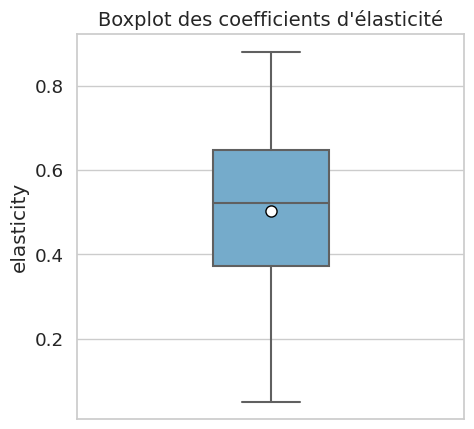

In [107]:
sns.set(font_scale=1.2, style='whitegrid')
fig, ax = plt.subplots(figsize=(5, 5))

_ = ax.set_title ('Boxplot des coefficients d\'élasticité', fontsize=14)

g = sns.boxplot(ax=ax, orient='v', y='elasticity', data=elasticity, palette='Blues', width=0.3,
                showmeans=True, showfliers=True, saturation=0.8, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})

plt.show();

### Test de génération des matrices de probabilités

In [108]:
def generate_incomes(n, pj):

    # On génère les revenus des parents (exprimés en logs) selon une loi normale
    # La moyenne et variance n'ont aucune incidence sur le calcul de la classe de revenu
    ln_y_parent = st.norm(0, 1).rvs(size=n, random_state=0)

    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0, 1).rvs(size=n, random_state=1)

    return np.exp(pj * ln_y_parent + residues), np.exp(ln_y_parent)

def quantiles(l, nb_quantiles):

    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) - 0.5 + 1./size)
    q_dict = {a:int(b) for a, b in zip(l_sorted, quantiles)}

    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):

    y_child = pd.Series(y_child) # revenu de l'enfant 
    y_parents = pd.Series(y_parents) # revenu des parents
    c_i_child = quantiles(y_child, nb_quantiles) # classe de revenu de l'enfant i
    c_i_parent = quantiles(y_parents, nb_quantiles) #  classe de revenu des parents de i
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ['y_child', 'y_parents', 'c_i_child', 'c_i_parent']

    return sample

def distribution(counts, nb_quantiles):

    distrib = []
    total = counts['counts'].sum()

    if total == 0 :

        return [0] * nb_quantiles

    for q_p in range(1, nb_quantiles+1):
        
        subset = counts[counts.c_i_parent == q_p]

        if len(subset):

            nb = subset['counts'].values[0]
            distrib = distrib + [nb / total]

        else:

            distrib = distrib + [0]

    return distrib

def conditional_distributions(sample, nb_quantiles):

    counts = sample.groupby(['c_i_child', 'c_i_parent']).apply(len)
    counts = counts.reset_index()
    counts.columns = ['c_i_child', 'c_i_parent', 'counts']
    mat = []

    for child_quantile in np.arange(nb_quantiles)+1:

        subset = counts[counts.c_i_child == child_quantile]
        mat = mat + [distribution(subset, nb_quantiles)]

    return np.array(mat)

def plot_conditional_distributions(p, cd, nb_quantiles):

    plt.figure(figsize=(10, 8))

    cumul = np.array([0] * nb_quantiles)

    for i, child_quantile in enumerate(cd):
        # graphique en stack bars
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1))
        cumul = cumul + np.array(child_quantile)

    #plt.axis([.5, nb_quantiles * 1.3 ,0 ,1])
    plt.axis([.5, nb_quantiles*1.05, 0, 1])
    plt.title(f'elasticity = {p}') 
    plt.legend(title='quantiles enfant', bbox_to_anchor =(1.1, 1), ncol = 1)
    plt.xlabel('quantiles parents')
    plt.ylabel('probabilité du quantile enfant')
    plt.show()
    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

### Test d'une matrice (un seul coefficient d'élasticité)

In [109]:
sns.set(font_scale=1.2, style='white')

# coefficient d'élasticité du pays j
pj = 0.8    

# nombre de quantiles (nombre de classes de revenu)
nb_quantiles = 10

# taille de l'échantillon
n  = 1000 * nb_quantiles

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)  # matrice de distribution

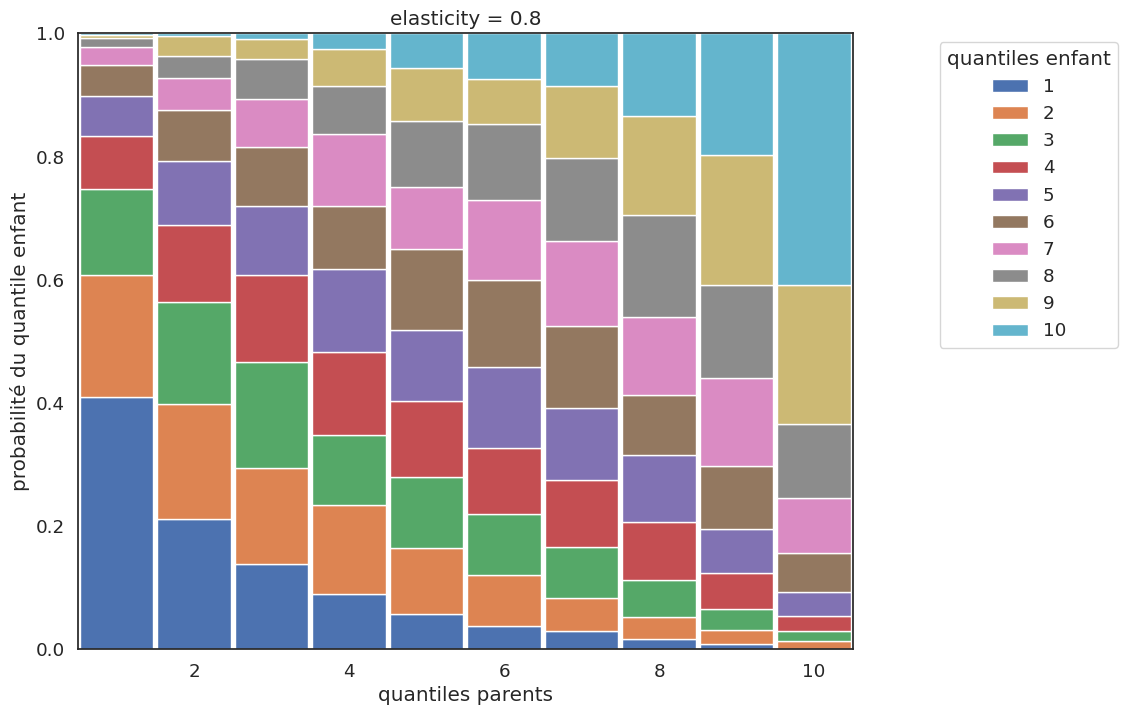

In [110]:
plot_conditional_distributions(pj, cd, nb_quantiles)

In [111]:
cd

array([[0.409, 0.212, 0.138, 0.09 , 0.058, 0.037, 0.029, 0.017, 0.009,
        0.001],
       [0.198, 0.186, 0.157, 0.144, 0.107, 0.084, 0.055, 0.035, 0.022,
        0.012],
       [0.14 , 0.166, 0.172, 0.114, 0.115, 0.099, 0.082, 0.061, 0.034,
        0.017],
       [0.086, 0.125, 0.14 , 0.134, 0.123, 0.107, 0.109, 0.093, 0.059,
        0.024],
       [0.065, 0.104, 0.113, 0.136, 0.116, 0.131, 0.116, 0.109, 0.071,
        0.039],
       [0.051, 0.082, 0.095, 0.101, 0.131, 0.142, 0.133, 0.098, 0.103,
        0.064],
       [0.029, 0.052, 0.078, 0.117, 0.1  , 0.129, 0.138, 0.126, 0.143,
        0.088],
       [0.015, 0.036, 0.066, 0.079, 0.107, 0.124, 0.135, 0.166, 0.151,
        0.121],
       [0.004, 0.032, 0.031, 0.059, 0.087, 0.073, 0.118, 0.161, 0.21 ,
        0.225],
       [0.003, 0.005, 0.01 , 0.026, 0.056, 0.074, 0.085, 0.134, 0.198,
        0.409]])

In [112]:
cd[0]

array([0.409, 0.212, 0.138, 0.09 , 0.058, 0.037, 0.029, 0.017, 0.009,
       0.001])

In [113]:
df_cd = pd.DataFrame(cd, index=['e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'e10'],
                     columns=['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10'])
df_cd

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10
e1,0.409,0.212,0.138,0.090,0.058,0.037,0.029,0.017,0.009,0.001
e2,0.198,0.186,0.157,0.144,0.107,0.084,0.055,0.035,0.022,0.012
e3,0.140,0.166,0.172,0.114,0.115,0.099,0.082,0.061,0.034,0.017
e4,0.086,0.125,0.140,0.134,0.123,0.107,0.109,0.093,0.059,0.024
e5,0.065,0.104,0.113,0.136,0.116,0.131,0.116,0.109,0.071,0.039
e6,0.051,0.082,0.095,0.101,0.131,0.142,0.133,0.098,0.103,0.064
e7,0.029,0.052,0.078,0.117,0.100,0.129,0.138,0.126,0.143,0.088
e8,0.015,0.036,0.066,0.079,0.107,0.124,0.135,0.166,0.151,0.121
e9,0.004,0.032,0.031,0.059,0.087,0.073,0.118,0.161,0.210,0.225
e10,0.003,0.005,0.010,0.026,0.056,0.074,0.085,0.134,0.198,0.409


In [114]:
# Use DataFrame.sum() method
df_cd.loc['sum', :] = df_cd.sum(axis=0)
df_cd

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10
e1,0.409,0.212,0.138,0.090,0.058,0.037,0.029,0.017,0.009,0.001
e2,0.198,0.186,0.157,0.144,0.107,0.084,0.055,0.035,0.022,0.012
e3,0.140,0.166,0.172,0.114,0.115,0.099,0.082,0.061,0.034,0.017
e4,0.086,0.125,0.140,0.134,0.123,0.107,0.109,0.093,0.059,0.024
e5,0.065,0.104,0.113,0.136,0.116,0.131,0.116,0.109,0.071,0.039
e6,0.051,0.082,0.095,0.101,0.131,0.142,0.133,0.098,0.103,0.064
e7,0.029,0.052,0.078,0.117,0.100,0.129,0.138,0.126,0.143,0.088
e8,0.015,0.036,0.066,0.079,0.107,0.124,0.135,0.166,0.151,0.121
e9,0.004,0.032,0.031,0.059,0.087,0.073,0.118,0.161,0.210,0.225
e10,0.003,0.005,0.010,0.026,0.056,0.074,0.085,0.134,0.198,0.409


In [115]:
# classe de revenu de l'enfant i
c_i_child = 1 
# classe de revenu des parents de i
c_i_parent = 1 

p = proba_cond(c_i_parent-1, c_i_child-1, cd)
print(f'\nP(c_i_parent = {c_i_parent} | c_i_child = {c_i_child}, pj = {pj}) = {p}')


P(c_i_parent = 1 | c_i_child = 1, pj = 0.8) = 0.409


In [116]:
# classe de revenu de l'enfant i
c_i_child = 1 
# classe de revenu des parents de i
c_i_parent = 10 

p = proba_cond(c_i_parent-1, c_i_child-1, cd)
print(f'\nP(c_i_parent = {c_i_parent} | c_i_child = {c_i_child}, pj = {pj}) = {p}')


P(c_i_parent = 10 | c_i_child = 1, pj = 0.8) = 0.001


In [117]:
# classe de revenu de l'enfant i
c_i_child = 10 
# classe de revenu des parents de i
c_i_parent = 10 

p = proba_cond(c_i_parent-1, c_i_child-1, cd)
print(f'\nP(c_i_parent = {c_i_parent} | c_i_child = {c_i_child}, pj = {pj}) = {p}')


P(c_i_parent = 10 | c_i_child = 10, pj = 0.8) = 0.409


### Génération des matrices de probabilité pour tous les pays et sauvegarde dans un dictionnaire

In [118]:
# mat_list = []

# # coefficient d'élasticité du pays j
# pj_list = elasticity['elasticity'].to_list()
# # nombre de quantiles (nombre de classes de revenu)
# nb_quantiles = 100
# # taille de l'échantillon
# n  = 1000 * nb_quantiles

# for pj in pj_list:

#     y_child, y_parents = generate_incomes(n, pj)
#     sample = compute_quantiles(y_child, y_parents, nb_quantiles)
#     # matrice de probabilités
#     cd = conditional_distributions(sample, nb_quantiles)
#     mat_list.append(cd)

# country_list = elasticity['country'].to_list()
# prob_dict = {key:value for (key, value) in zip(country_list, mat_list)}
# prob_dict['ALB']

# # Save the dictionnary
# dump(prob_dict, 'prob_dict.joblib');

#### Merge : enrichissement du dataset de la World Income Distribution avec les données de population, l'indice de Gini, le coefficient d'élasticité

In [119]:
idd[:5]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


In [120]:
idd.shape

(11600, 6)

In [121]:
pop[:5]

,Area Code (ISO3),Population
0,AFG,27722276.0
1,ALB,3002678.0
2,DZA,34730608.0
3,ASM,57492.0
4,AND,83862.0


In [122]:
gini[:5]

,Country Name,Country Code,Gini index
0,Angola,AGO,49
1,Albania,ALB,32
2,United Arab Emirates,ARE,29
3,Argentina,ARG,45
4,Armenia,ARM,32


In [123]:
gini = gini.rename(columns={'Country Code': 'country'})

In [124]:
idd['year_survey'].unique()

array([2008, 2009, 2010, 2007, 2006, 2011, 2004])

In [125]:
idd['nb_quantiles'].unique()

array([100])

In [126]:
i0 = idd.loc[:, ['country', 'quantile', 'income']]
i0[:5]

,country,quantile,income
0,ALB,1,728.89795
1,ALB,2,916.66235
2,ALB,3,1010.91600
3,ALB,4,1086.90780
4,ALB,5,1132.69970


In [127]:
i0.shape

(11600, 3)

In [128]:
pop = pop.rename(columns={'Area Code (ISO3)': 'country'})
pop[:5]

,country,Population
0,AFG,27722276.0
1,ALB,3002678.0
2,DZA,34730608.0
3,ASM,57492.0
4,AND,83862.0


In [129]:
pop.shape

(248, 2)

In [130]:
gini.shape

(163, 3)

In [131]:
i1 = pd.merge(i0, pop, how='left', on='country')
i1

,country,quantile,income,Population
0,ALB,1,728.89795,3002678.0
1,ALB,2,916.66235,3002678.0
2,ALB,3,1010.91600,3002678.0
3,ALB,4,1086.90780,3002678.0
4,ALB,5,1132.69970,3002678.0
...,...,...,...,...
11595,ZAF,96,24553.56800,49779471.0
11596,ZAF,97,28858.03100,49779471.0
11597,ZAF,98,35750.29000,49779471.0
11598,ZAF,99,46297.31600,49779471.0


In [132]:
i2 = pd.merge(i1, gini, how='left', on='country')
i2[:5]

,country,quantile,income,Population,Country Name,Gini index
0,ALB,1,728.89795,3002678.0,Albania,32.0
1,ALB,2,916.66235,3002678.0,Albania,32.0
2,ALB,3,1010.91600,3002678.0,Albania,32.0
3,ALB,4,1086.90780,3002678.0,Albania,32.0
4,ALB,5,1132.69970,3002678.0,Albania,32.0


In [133]:
i3 = elasticity.loc[:, ['country', 'elasticity']].copy()
i3

,country,elasticity
0,AFG,0.336376
1,AGO,0.501068
2,ALB,0.668573
3,ARG,0.594954
4,ARM,0.321540
...,...,...
148,VUT,0.365555
149,XKX,0.547309
150,YEM,0.675573
151,ZAF,0.638598


In [134]:
i4 = pd.merge(i2, i3, how='left', on='country')
i4[:5]

,country,quantile,income,Population,Country Name,Gini index,elasticity
0,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573
1,ALB,2,916.66235,3002678.0,Albania,32.0,0.668573
2,ALB,3,1010.91600,3002678.0,Albania,32.0,0.668573
3,ALB,4,1086.90780,3002678.0,Albania,32.0,0.668573
4,ALB,5,1132.69970,3002678.0,Albania,32.0,0.668573


In [135]:
i4.shape

(11600, 7)

In [136]:
i4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11600 entries, 0 to 11599
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11600 non-null  object 
 1   quantile      11600 non-null  int64  
 2   income        11600 non-null  float64
 3   Population    11400 non-null  float64
 4   Country Name  11400 non-null  object 
 5   Gini index    11400 non-null  float64
 6   elasticity    11400 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 634.5+ KB


In [137]:
# Valeurs manquantes
i4.isna().sum()

country           0
quantile          0
income            0
Population      200
Country Name    200
Gini index      200
elasticity      200
dtype: int64

In [138]:
i4['elasticity'].isna()
i4.loc[i4['elasticity'].isna(), 'country'].unique()

array(['LUX', 'SYR'], dtype=object)

In [139]:
i4['Gini index'].isna()
#i4.loc[i4['Gini index'].isna(), :]
i4.loc[i4['Gini index'].isna(), 'country'].unique()

array(['KHM', 'TWN'], dtype=object)

In [140]:
i4['Country Name'].isna()
#i4.loc[i4['Country Name'].isna(), :]
i4.loc[i4['Country Name'].isna(), 'country'].unique()

array(['KHM', 'TWN'], dtype=object)

In [141]:
i4['Population'].isna()
#i4.loc[i4['Population'].isna(), :]
i4.loc[i4['Population'].isna(), 'country'].unique()

array(['SDN', 'XKX'], dtype=object)

In [142]:
dl = ['LUX', 'SYR', 'KHM', 'TWN', 'XKX', 'SDN']
i4 = i4.drop(index=i4.loc[i4['country'].isin(dl), :].index)
i4.isna().sum()

country         0
quantile        0
income          0
Population      0
Country Name    0
Gini index      0
elasticity      0
dtype: int64

In [143]:
i4.shape

(11000, 7)

In [144]:
# Duplicate (most commonly rows of data that are exactly the same across all columns)
i4.duplicated().any()

False

In [145]:
i4.describe(include='all')

,country,quantile,income,Population,Country Name,Gini index,elasticity
count,11000,11000.000000,11000.000000,1.100000e+04,11000,11000.000000,11000.000000
unique,110,NaN,NaN,NaN,110,NaN,NaN
top,ALB,NaN,NaN,NaN,Albania,NaN,NaN
freq,100,NaN,NaN,NaN,100,NaN,NaN
mean,NaN,50.500000,5971.514392,5.611368e+07,NaN,37.900000,0.528716
std,NaN,28.867382,9216.044332,1.760070e+08,NaN,7.796566,0.165857
min,NaN,1.000000,16.719418,3.108560e+05,NaN,25.000000,0.108344
25%,NaN,25.750000,905.144153,4.771019e+06,NaN,32.000000,0.403847
50%,NaN,50.500000,2450.478250,1.386716e+07,NaN,36.000000,0.533524
75%,NaN,75.250000,7403.364075,4.185394e+07,NaN,43.000000,0.663425


In [146]:
i4[:5]

,country,quantile,income,Population,Country Name,Gini index,elasticity
0,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573
1,ALB,2,916.66235,3002678.0,Albania,32.0,0.668573
2,ALB,3,1010.91600,3002678.0,Albania,32.0,0.668573
3,ALB,4,1086.90780,3002678.0,Albania,32.0,0.668573
4,ALB,5,1132.69970,3002678.0,Albania,32.0,0.668573


In [147]:
i4_means = i4.groupby('country')[['income']].mean()
i4_means = i4_means.reset_index()
i4_means

,country,income
0,ALB,2994.829902
1,ARG,5847.884654
2,ARM,1628.382785
3,AUT,16637.600204
4,AZE,2357.429023
...,...,...
105,USA,25503.581661
106,VEN,3167.147724
107,VNM,1377.773966
108,YEM,1042.635870


In [148]:
i4 = i4.rename(columns={'income': 'income_ref'})
i4

,country,quantile,income_ref,Population,Country Name,Gini index,elasticity
0,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573
1,ALB,2,916.66235,3002678.0,Albania,32.0,0.668573
2,ALB,3,1010.91600,3002678.0,Albania,32.0,0.668573
3,ALB,4,1086.90780,3002678.0,Albania,32.0,0.668573
4,ALB,5,1132.69970,3002678.0,Albania,32.0,0.668573
...,...,...,...,...,...,...,...
11595,ZAF,96,24553.56800,49779471.0,South Africa,62.0,0.638598
11596,ZAF,97,28858.03100,49779471.0,South Africa,62.0,0.638598
11597,ZAF,98,35750.29000,49779471.0,South Africa,62.0,0.638598
11598,ZAF,99,46297.31600,49779471.0,South Africa,62.0,0.638598


In [149]:
i4 = pd.merge(i4, i4_means, how='left', on='country')
i4

,country,quantile,income_ref,Population,Country Name,Gini index,elasticity,income
0,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573,2994.829902
1,ALB,2,916.66235,3002678.0,Albania,32.0,0.668573,2994.829902
2,ALB,3,1010.91600,3002678.0,Albania,32.0,0.668573,2994.829902
3,ALB,4,1086.90780,3002678.0,Albania,32.0,0.668573,2994.829902
4,ALB,5,1132.69970,3002678.0,Albania,32.0,0.668573,2994.829902
...,...,...,...,...,...,...,...,...
10995,ZAF,96,24553.56800,49779471.0,South Africa,62.0,0.638598,5617.904880
10996,ZAF,97,28858.03100,49779471.0,South Africa,62.0,0.638598,5617.904880
10997,ZAF,98,35750.29000,49779471.0,South Africa,62.0,0.638598,5617.904880
10998,ZAF,99,46297.31600,49779471.0,South Africa,62.0,0.638598,5617.904880


In [150]:
i4_ref = i4.loc[:, ['country', 'quantile', 'income_ref']]
i4_ref = i4_ref.rename(columns={'quantile': 'quantile_parent', 'income_ref': 'income_parent'})
i4_ref

,country,quantile_parent,income_parent
0,ALB,1,728.89795
1,ALB,2,916.66235
2,ALB,3,1010.91600
3,ALB,4,1086.90780
4,ALB,5,1132.69970
...,...,...,...
10995,ZAF,96,24553.56800
10996,ZAF,97,28858.03100
10997,ZAF,98,35750.29000
10998,ZAF,99,46297.31600


In [151]:
i4 = i4.rename(columns={'income_ref': 'income_enfant', 'Gini index': 'Gini_index' })
i4

,country,quantile,income_enfant,Population,Country Name,Gini_index,elasticity,income
0,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573,2994.829902
1,ALB,2,916.66235,3002678.0,Albania,32.0,0.668573,2994.829902
2,ALB,3,1010.91600,3002678.0,Albania,32.0,0.668573,2994.829902
3,ALB,4,1086.90780,3002678.0,Albania,32.0,0.668573,2994.829902
4,ALB,5,1132.69970,3002678.0,Albania,32.0,0.668573,2994.829902
...,...,...,...,...,...,...,...,...
10995,ZAF,96,24553.56800,49779471.0,South Africa,62.0,0.638598,5617.904880
10996,ZAF,97,28858.03100,49779471.0,South Africa,62.0,0.638598,5617.904880
10997,ZAF,98,35750.29000,49779471.0,South Africa,62.0,0.638598,5617.904880
10998,ZAF,99,46297.31600,49779471.0,South Africa,62.0,0.638598,5617.904880


In [152]:
i4['id'] = 1
i4['quantile_parent'] = 0
i4[:5]

,country,quantile,income_enfant,Population,Country Name,Gini_index,elasticity,income,id,quantile_parent
0,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573,2994.829902,1,0
1,ALB,2,916.66235,3002678.0,Albania,32.0,0.668573,2994.829902,1,0
2,ALB,3,1010.91600,3002678.0,Albania,32.0,0.668573,2994.829902,1,0
3,ALB,4,1086.90780,3002678.0,Albania,32.0,0.668573,2994.829902,1,0
4,ALB,5,1132.69970,3002678.0,Albania,32.0,0.668573,2994.829902,1,0


In [153]:
i4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          11000 non-null  object 
 1   quantile         11000 non-null  int64  
 2   income_enfant    11000 non-null  float64
 3   Population       11000 non-null  float64
 4   Country Name     11000 non-null  object 
 5   Gini_index       11000 non-null  float64
 6   elasticity       11000 non-null  float64
 7   income           11000 non-null  float64
 8   id               11000 non-null  int64  
 9   quantile_parent  11000 non-null  int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 859.5+ KB


In [154]:
i4['country'].nunique()

110

In [155]:
i4[:5]

,country,quantile,income_enfant,Population,Country Name,Gini_index,elasticity,income,id,quantile_parent
0,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573,2994.829902,1,0
1,ALB,2,916.66235,3002678.0,Albania,32.0,0.668573,2994.829902,1,0
2,ALB,3,1010.91600,3002678.0,Albania,32.0,0.668573,2994.829902,1,0
3,ALB,4,1086.90780,3002678.0,Albania,32.0,0.668573,2994.829902,1,0
4,ALB,5,1132.69970,3002678.0,Albania,32.0,0.668573,2994.829902,1,0


In [156]:
nb_pays = i4['country'].nunique()
print(f'Nombre de pays représentés : {nb_pays}')

Nombre de pays représentés : 110


#### Pourcentage de la population mondiale couverte

In [157]:
pop_couv = i4.groupby('country')['Population'].unique().sum().item()
pop_couv

6172504917.0

In [158]:
print(f'Les données couvrent {int(np.round((pop_couv / 7003000000)*100))} % de la population mondiale')

Les données couvrent 88 % de la population mondiale


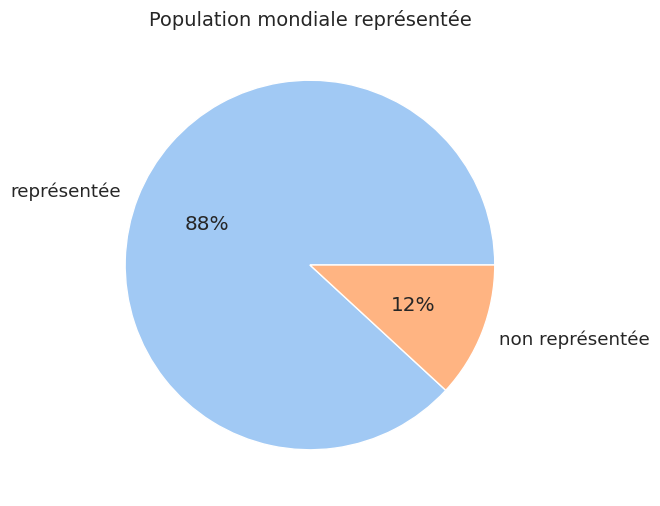

In [159]:
plt.figure(figsize=(8, 6))

#define data
data = [6172504917, (7003000000-6172504917)]
labels = ['représentée', 'non représentée']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Population mondiale représentée', fontsize=14)
plt.show()

In [160]:
i4

,country,quantile,income_enfant,Population,Country Name,Gini_index,elasticity,income,id,quantile_parent
0,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573,2994.829902,1,0
1,ALB,2,916.66235,3002678.0,Albania,32.0,0.668573,2994.829902,1,0
2,ALB,3,1010.91600,3002678.0,Albania,32.0,0.668573,2994.829902,1,0
3,ALB,4,1086.90780,3002678.0,Albania,32.0,0.668573,2994.829902,1,0
4,ALB,5,1132.69970,3002678.0,Albania,32.0,0.668573,2994.829902,1,0
...,...,...,...,...,...,...,...,...,...,...
10995,ZAF,96,24553.56800,49779471.0,South Africa,62.0,0.638598,5617.904880,1,0
10996,ZAF,97,28858.03100,49779471.0,South Africa,62.0,0.638598,5617.904880,1,0
10997,ZAF,98,35750.29000,49779471.0,South Africa,62.0,0.638598,5617.904880,1,0
10998,ZAF,99,46297.31600,49779471.0,South Africa,62.0,0.638598,5617.904880,1,0


### Clonage du dataset, on veut travailler sur un dataset de 500 individus

In [161]:
# Clonage : on veut un dataset de 500 individus
i5 = pd.concat([i4]*500, ignore_index=True)

In [162]:
i5.shape

(5500000, 10)

In [163]:
i4.shape[0]

11000

In [164]:
a = np.arange(1, 501)
b = np.repeat(a, 11000, axis=0)

In [165]:
i5['id'] = b

In [166]:
i5[-5:]

,country,quantile,income_enfant,Population,Country Name,Gini_index,elasticity,income,id,quantile_parent
5499995,ZAF,96,24553.568,49779471.0,South Africa,62.0,0.638598,5617.90488,500,0
5499996,ZAF,97,28858.031,49779471.0,South Africa,62.0,0.638598,5617.90488,500,0
5499997,ZAF,98,35750.290,49779471.0,South Africa,62.0,0.638598,5617.90488,500,0
5499998,ZAF,99,46297.316,49779471.0,South Africa,62.0,0.638598,5617.90488,500,0
5499999,ZAF,100,82408.550,49779471.0,South Africa,62.0,0.638598,5617.90488,500,0


In [167]:
i6 = i5.copy()

In [168]:
wid = i6.copy()

### Tri du dataframe par pays et par quantile enfant, pour permettre par la suite la bonne distribution des quantiles parents

In [169]:
wid = wid.sort_values(by=['country', 'quantile'])
wid = wid.reset_index(drop=True)
wid

,country,quantile,income_enfant,Population,Country Name,Gini_index,elasticity,income,id,quantile_parent
0,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573,2994.829902,1,0
1,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573,2994.829902,2,0
2,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573,2994.829902,3,0
3,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573,2994.829902,4,0
4,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573,2994.829902,5,0
...,...,...,...,...,...,...,...,...,...,...
5499995,ZAF,100,82408.55000,49779471.0,South Africa,62.0,0.638598,5617.904880,496,0
5499996,ZAF,100,82408.55000,49779471.0,South Africa,62.0,0.638598,5617.904880,497,0
5499997,ZAF,100,82408.55000,49779471.0,South Africa,62.0,0.638598,5617.904880,498,0
5499998,ZAF,100,82408.55000,49779471.0,South Africa,62.0,0.638598,5617.904880,499,0


In [170]:
(wid['country'] == 'ALB').value_counts()

country
False    5450000
True       50000
Name: count, dtype: int64

#### Chargement du dictionnaire des matrices de probabilités

In [171]:
# Load the dictionnary
prob_dict = load('prob_dict.joblib')

In [172]:
len(prob_dict.keys())

153

In [173]:
prob_dict['ALB']

array([[0.155, 0.09 , 0.067, ..., 0.001, 0.   , 0.   ],
       [0.081, 0.073, 0.051, ..., 0.001, 0.   , 0.   ],
       [0.074, 0.066, 0.049, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.047, 0.045, 0.084],
       [0.   , 0.   , 0.   , ..., 0.055, 0.078, 0.091],
       [0.   , 0.   , 0.   , ..., 0.08 , 0.082, 0.155]])

In [174]:
print(prob_dict['ALB'].shape)
print(prob_dict['ALB'][:, :1].sum())
print(prob_dict['ALB'][:1, :].sum())

(100, 100)
1.0
1.0


In [175]:
prob_dict['ALB'][0]

array([0.155, 0.09 , 0.067, 0.057, 0.058, 0.033, 0.037, 0.035, 0.025,
       0.032, 0.03 , 0.024, 0.027, 0.017, 0.014, 0.022, 0.02 , 0.007,
       0.013, 0.004, 0.014, 0.013, 0.008, 0.005, 0.01 , 0.007, 0.011,
       0.006, 0.007, 0.008, 0.012, 0.007, 0.006, 0.008, 0.014, 0.006,
       0.003, 0.003, 0.007, 0.006, 0.   , 0.009, 0.003, 0.002, 0.002,
       0.002, 0.003, 0.004, 0.003, 0.004, 0.004, 0.   , 0.   , 0.002,
       0.001, 0.003, 0.001, 0.001, 0.   , 0.002, 0.001, 0.002, 0.001,
       0.001, 0.002, 0.001, 0.001, 0.   , 0.002, 0.001, 0.002, 0.   ,
       0.001, 0.001, 0.   , 0.   , 0.001, 0.002, 0.002, 0.   , 0.   ,
       0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.001,
       0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.001, 0.   ,
       0.   ])

In [176]:
500 * prob_dict['ALB'][0]

array([77.5, 45. , 33.5, 28.5, 29. , 16.5, 18.5, 17.5, 12.5, 16. , 15. ,
       12. , 13.5,  8.5,  7. , 11. , 10. ,  3.5,  6.5,  2. ,  7. ,  6.5,
        4. ,  2.5,  5. ,  3.5,  5.5,  3. ,  3.5,  4. ,  6. ,  3.5,  3. ,
        4. ,  7. ,  3. ,  1.5,  1.5,  3.5,  3. ,  0. ,  4.5,  1.5,  1. ,
        1. ,  1. ,  1.5,  2. ,  1.5,  2. ,  2. ,  0. ,  0. ,  1. ,  0.5,
        1.5,  0.5,  0.5,  0. ,  1. ,  0.5,  1. ,  0.5,  0.5,  1. ,  0.5,
        0.5,  0. ,  1. ,  0.5,  1. ,  0. ,  0.5,  0.5,  0. ,  0. ,  0.5,
        1. ,  1. ,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,
        0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0.5,  0. ,  0. ,  0.5,  0. ,
        0. ])

#### Explication du calcul du nombre d'individus auxquels attribuer une classe parent

### Répartition des classes de revenus des parents

In [177]:
def my_function(series):
    '''
    Cette fonction a pour but le calcul des arrondis à somme constante (500 individus).
    En effet le calcul du nombre d'individus auxquels attribuer une classe parent donne soit un entier soit un décimal en .5.
    Cette fonction a pour but le calcul des arrondis, alternativement à l'entier supérieur et à l'entier inférieur, de manière à garder la somme constante.
    '''
    res = []
    toggle = True
    for num in series:
        if np.modf(num)[0] == 0:
                res.append(num)
        else:
            if toggle:
                res.append(np.ceil(num))
                toggle = not(toggle)
            else:
                res.append(np.floor(num))
                toggle = not(toggle)
    return res

In [178]:
# TEST 1

test = prob_dict['ALB']*500
result = []
i=0
my_list = []
for count, value in enumerate(test[i]):
    my_list.extend(np.full((int(np.ceil(value)), ), count))
my_list = my_list[:500]
result.extend(my_list)
print(len(result))
print(sum(result))
print(np.unique(result))

500
5761
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 41 42 43 44 45 46 47 48
 49 50 53 54 55 56 57]


In [179]:
# TEST 2

test = np.apply_along_axis(my_function, 0, prob_dict['ALB']*500)
result = []
i=0
my_list = []
for count, value in enumerate(test[i]):
    my_list.extend(np.full((int((value)), ), count))
my_list = my_list[:500]
result.extend(my_list)
print(len(result))
print(sum(result))
print(np.unique(result))

500
5761
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 41 42 43 44 45 46 47 48
 49 50 53 54 55 56 57]


In [180]:
# TEST 3

test = np.apply_along_axis(my_function, 0, prob_dict['ALB']*500)
test

array([[78., 45., 34., ...,  1.,  0.,  0.],
       [40., 37., 25., ...,  0.,  0.,  0.],
       [37., 33., 25., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 24., 22., 42.],
       [ 0.,  0.,  0., ..., 27., 39., 46.],
       [ 0.,  0.,  0., ..., 40., 41., 77.]])

In [181]:
# TEST 4

# somme par colonne
np.sum(test, axis=0)

array([500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500.])

In [182]:
result = []
ni = 500 
# 500 = nombre de clones, et coefficient multiplicateur de la probabilité, 
# qui détermine le nombre d'individus (enfants) auxquels attribuer un quantile parent donné

liste_pays = wid['country'].unique()

for pays in liste_pays:
    prob_mat = np.apply_along_axis(my_function, 0, ni * prob_dict[pays])
    for i in range(100):
        my_list = []
        for count, value in enumerate(prob_mat[i], start=1):
            my_list.extend(np.full((int((value)), ), count))
        result.extend(my_list)

print(len(result))
print(sum(result))
print(np.unique(result))

wid['quantile_parent'] = result
# wid.to_csv('wid.csv', index=False)

5500000
277750000
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


### Autre méthode pour la répartition des classes de revenus des parents

In [183]:
# result = []
# ni = 500 # nombre de clones
# liste_pays = wid['country'].unique()
# mat_classes, _ = np.mgrid[1:101, 1:501]

# for pays in liste_pays:
#     prob_mat = np.apply_along_axis(my_function, 0, ni * prob_dict[pays]) 
#     for i in range (100):
#         my_list = []
#         for count, value in enumerate(prob_mat[i], start=0):
#             my_list.extend(mat_classes[count, :int((value))])
#         result.extend(my_list)

# print(len(result))
# print(sum(result))
# print(np.unique(result))

# <a name="M4">Mission 4, explication du revenu des individus en fonction du revenu moyen du pays, de l'indice de Gini du pays, de la classe de revenus des parents.</a>

In [184]:
i4_ref[:3]

,country,quantile_parent,income_parent
0,ALB,1,728.89795
1,ALB,2,916.66235
2,ALB,3,1010.91600


In [185]:
wid

,country,quantile,income_enfant,Population,Country Name,Gini_index,elasticity,income,id,quantile_parent
0,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573,2994.829902,1,1
1,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573,2994.829902,2,1
2,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573,2994.829902,3,1
3,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573,2994.829902,4,1
4,ALB,1,728.89795,3002678.0,Albania,32.0,0.668573,2994.829902,5,1
...,...,...,...,...,...,...,...,...,...,...
5499995,ZAF,100,82408.55000,49779471.0,South Africa,62.0,0.638598,5617.904880,496,100
5499996,ZAF,100,82408.55000,49779471.0,South Africa,62.0,0.638598,5617.904880,497,100
5499997,ZAF,100,82408.55000,49779471.0,South Africa,62.0,0.638598,5617.904880,498,100
5499998,ZAF,100,82408.55000,49779471.0,South Africa,62.0,0.638598,5617.904880,499,100


In [186]:
wid = pd.merge(wid, i4_ref, how='left', on=['country', 'quantile_parent'])

In [187]:
wid.describe(include='all')

,country,quantile,income_enfant,Population,Country Name,Gini_index,elasticity,income,id,quantile_parent,income_parent
count,5500000,5.500000e+06,5.500000e+06,5.500000e+06,5500000,5.500000e+06,5.500000e+06,5.500000e+06,5.500000e+06,5.500000e+06,5.500000e+06
unique,110,NaN,NaN,NaN,110,NaN,NaN,NaN,NaN,NaN,NaN
top,ALB,NaN,NaN,NaN,Albania,NaN,NaN,NaN,NaN,NaN,NaN
freq,50000,NaN,NaN,NaN,50000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.050000e+01,5.971514e+03,5.611368e+07,NaN,3.790000e+01,5.287162e-01,5.971514e+03,2.505000e+02,5.050000e+01,5.971514e+03
std,NaN,2.886607e+01,9.215626e+03,1.759990e+08,NaN,7.796212e+00,1.658499e-01,6.421472e+03,1.443373e+02,2.886607e+01,9.215626e+03
min,NaN,1.000000e+00,1.671942e+01,3.108560e+05,NaN,2.500000e+01,1.083443e-01,2.760160e+02,1.000000e+00,1.000000e+00,1.671942e+01
25%,NaN,2.575000e+01,9.051442e+02,4.771019e+06,NaN,3.200000e+01,4.038472e-01,1.377774e+03,1.257500e+02,2.575000e+01,9.051442e+02
50%,NaN,5.050000e+01,2.450478e+03,1.386716e+07,NaN,3.600000e+01,5.335241e-01,3.307303e+03,2.505000e+02,5.050000e+01,2.450478e+03
75%,NaN,7.525000e+01,7.403364e+03,4.185394e+07,NaN,4.300000e+01,6.634245e-01,7.051610e+03,3.752500e+02,7.525000e+01,7.403364e+03


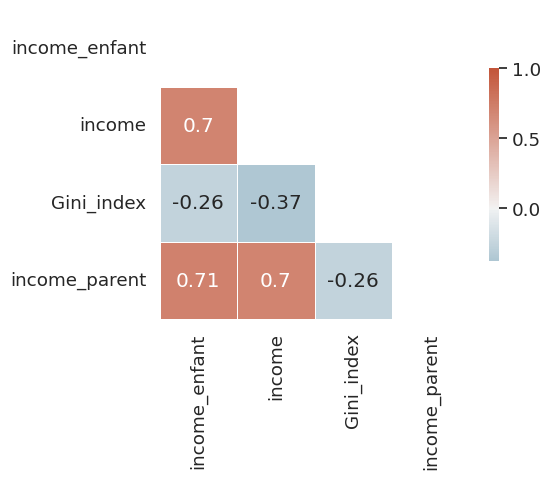

In [188]:
col_names = ['income_enfant', 'income', 'Gini_index', 'income_parent']

# Compute the correlation matrix
corr = wid[col_names].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={'shrink': .5},
            annot=True);

#### Vérifier la colinéarité des variables

In [189]:
# Compute VIF data for each independent variable
# Typically VIF value > 10 indicates the presence of multicollinearity

vif = pd.DataFrame()
col_names = ['income_enfant', 'income', 'Gini_index', 'income_parent']
vif['features'] = col_names
vif['vif_factor'] = [variance_inflation_factor(wid[col_names].to_numpy(), i) for i in range(len(col_names))]
vif

,features,vif_factor
0,income_enfant,3.413841
1,income,4.046957
2,Gini_index,1.598695
3,income_parent,3.413841


In [190]:
# Ajout des versions logarithmiques des incomes (log base e)

wid['log_income'] = wid['income'].apply(np.log)
wid['log_income_enfant'] = wid['income_enfant'].apply(np.log)

In [191]:
# version logarithmique des incomes (log base e)
np.log(1)

0.0

In [192]:
wid_sample = wid.sample(100000).copy()
wid_sample[:5]

,country,quantile,income_enfant,Population,Country Name,Gini_index,elasticity,income,id,quantile_parent,income_parent,log_income,log_income_enfant
1151260,CYP,3,6212.5930,1081563.0,Cyprus,32.0,0.783071,17345.387463,261,10,8330.56400,9.761082,8.734334
418229,BGR,37,3314.6045,7524087.0,Bulgaria,37.0,0.528703,4984.978559,230,35,3234.27080,8.514184,8.106094
4167487,PER,35,1585.9058,28562317.0,Peru,47.0,0.663425,3330.533349,488,85,5213.69530,8.110888,7.368911
4746217,SVN,93,19834.9880,2023052.0,Slovenia,25.0,0.501857,12106.007475,218,65,12776.32700,9.401457,9.895203
3775243,NER,51,477.7465,15250908.0,Niger,37.0,0.359710,650.129353,244,43,431.06055,6.477171,6.169080


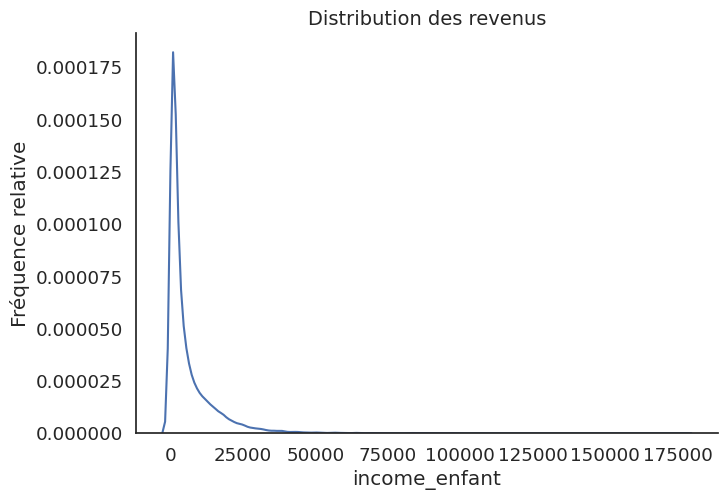

In [193]:
sns.displot(data=wid_sample, x='income_enfant', log_scale=False, height=5, aspect=1.5, kind='kde')
plt.ylabel('Fréquence relative')
plt.xlabel('income_enfant')
plt.title('Distribution des revenus', fontsize=14)
plt.show()

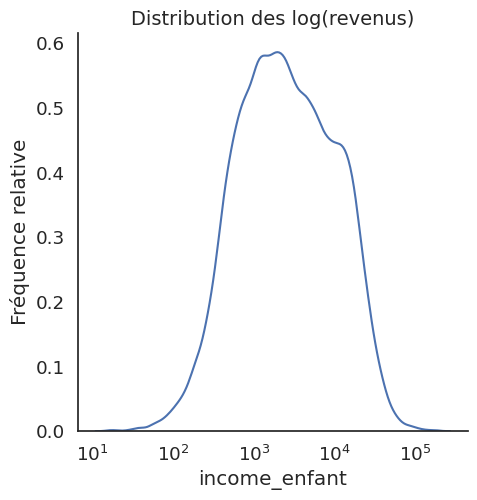

In [194]:
sns.displot(data=wid_sample, x='income_enfant', log_scale=True, height=5, aspect=1, kind='kde')
plt.ylabel('Fréquence relative')
plt.xlabel('income_enfant')
plt.title('Distribution des log(revenus)', fontsize=14)
plt.show()

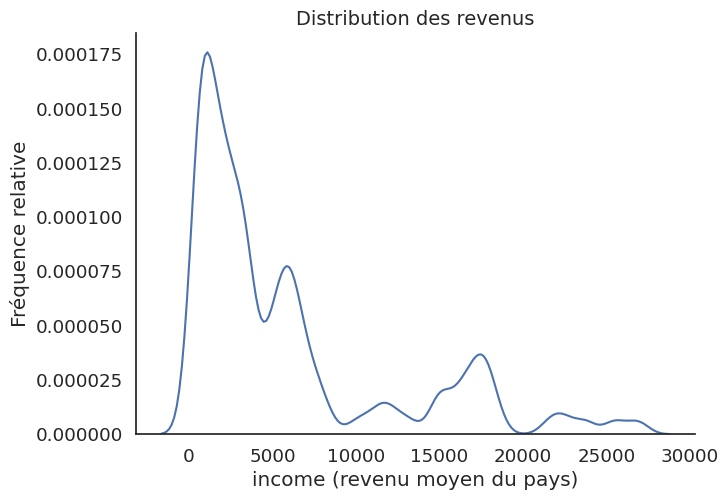

In [195]:
sns.displot(data=wid_sample, x='income', log_scale=False, height=5, aspect=1.5, kind='kde')
plt.ylabel('Fréquence relative')
plt.xlabel('income (revenu moyen du pays)')
plt.title('Distribution des revenus', fontsize=14)
plt.show()

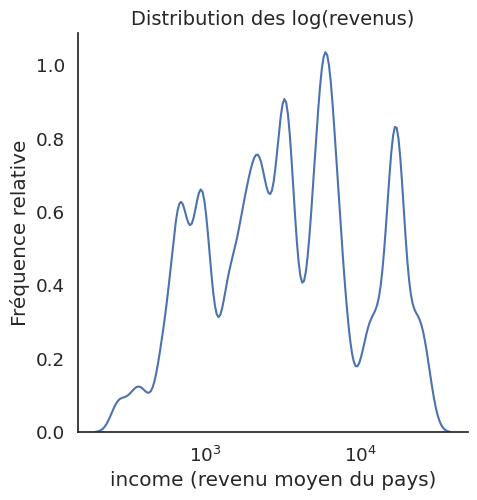

In [196]:
sns.displot(data=wid_sample, x='income', log_scale=True, height=5, aspect=1, kind='kde')
plt.ylabel('Fréquence relative')
plt.xlabel('income (revenu moyen du pays)')
plt.title('Distribution des log(revenus)', fontsize=14)
plt.show()

In [197]:
# features
X = wid_sample[['log_income', 'Gini_index', 'quantile_parent']]

# target output
y = wid_sample['log_income_enfant']

In [198]:
# Top k features

estimator = f_regression
selector = SelectKBest(estimator, k=3)
selector = selector.fit(X, y)
d = {'Features': X.columns, 'Keep': selector.get_support(), 'Scores': selector.scores_}
features = pd.DataFrame(data = d).sort_values(by='Scores', ascending=False).reset_index(drop=True)
features['Scores'] = features['Scores'].apply(int)
features.set_index('Features')

,Keep,Scores
Features,,
log_income,True,245827
Gini_index,True,13478
quantile_parent,True,5459


### LinearRegression

In [199]:
wid_sample[:5]

,country,quantile,income_enfant,Population,Country Name,Gini_index,elasticity,income,id,quantile_parent,income_parent,log_income,log_income_enfant
1151260,CYP,3,6212.5930,1081563.0,Cyprus,32.0,0.783071,17345.387463,261,10,8330.56400,9.761082,8.734334
418229,BGR,37,3314.6045,7524087.0,Bulgaria,37.0,0.528703,4984.978559,230,35,3234.27080,8.514184,8.106094
4167487,PER,35,1585.9058,28562317.0,Peru,47.0,0.663425,3330.533349,488,85,5213.69530,8.110888,7.368911
4746217,SVN,93,19834.9880,2023052.0,Slovenia,25.0,0.501857,12106.007475,218,65,12776.32700,9.401457,9.895203
3775243,NER,51,477.7465,15250908.0,Niger,37.0,0.359710,650.129353,244,43,431.06055,6.477171,6.169080


In [200]:
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(X, y)

LinearRegression(n_jobs=-1)

In [201]:
# Make predictions
y_pred = lin_reg.predict(X)

In [202]:
# RMSE
error = rmse(np.exp(y), np.exp(y_pred))
print(f'RMSE :      {int(error)}')

# Comparaison avec la variance RMSE doit être plus faible
print('Variance : ', int(np.std(wid_sample['income_enfant'])))

RMSE :      6097
Variance :  9155


In [203]:
print(f'R2: {np.round(lin_reg.score(X, y), 2)}')

R2: 0.77


Le modèle permet d’expliquer 77 % du revenu des individus avec trois variables :

> - le revenu moyen du pays de naissance
> - l'indice de Gini du pays de naissance
> - le revenu des parents

Les 33 % non expliqués peuvent être liés à des facteurs non considérés dans le modèle comme la chance, le niveau d'étude, la volonté...